In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd

conn = sqlite3.connect('capstone2.db', timeout=10)

The goal is to train 4 different models, one per company. The training data will compose of the data for 5/15/19 to 6/15/19. The testing data will be for 6/16/19 to 6/26/19.

## Import Data from SQLite

In [2]:
tweets_df = pd.read_sql_query('SELECT * FROM tweets_df;', parse_dates = ['created_at'], con = conn)

In [35]:
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
ts = TimeSeries(key='D0D213LZDE18R8MB',  output_format='pandas')

stock = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
i = 0
stocks_df = pd.DataFrame(columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'Company'])
date_range = pd.date_range(start = '2019-05-15', end = '2019-06-26')
date_range = date_range.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
dates = pd.DataFrame({'date': date_range})
for table in range(4):
    data, meta_data = ts.get_daily(stock[i])
    data.reset_index(level=0, inplace=True)
    data = data[data.date > '2019-05-14'].reset_index(drop=True)
    data.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    data['Company'] = stock[i]
    data = dates.merge(data, how='left', on = 'date')
    data['date'] = data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
    data = data.interpolate(method='linear', limit_direction = 'forward')
    data = data.fillna(method='ffill')
    stocks_df = pd.concat([stocks_df, data])
    i+=1

In [4]:
netflix_tweets_test = pd.read_sql_query('SELECT * FROM netflix_tweets_test', parse_dates = ['created_at'], con = conn)
disney_tweets_test = pd.read_sql_query('SELECT * FROM disney_tweets_test', parse_dates = ['created_at'], con = conn)
amazon_tweets_test = pd.read_sql_query('SELECT * FROM amazon_tweets_test', parse_dates = ['created_at'], con = conn)
google_tweets_test = pd.read_sql_query('SELECT * FROM google_tweets_test', parse_dates = ['created_at'], con = conn)
tables = [netflix_tweets_test, disney_tweets_test, amazon_tweets_test, google_tweets_test]
for table in tables:
    table.created_at = table.created_at.apply(lambda x: x.date())

In [5]:
netflix_tweets = tweets_df[tweets_df.Company == 'NFLX'].reset_index(drop=True)
amazon_tweets = tweets_df[tweets_df.Company == 'AMZN'].reset_index(drop=True)
disney_tweets = tweets_df[tweets_df.Company == 'DIS'].reset_index(drop=True)
google_tweets = tweets_df[tweets_df.Company == 'GOOGL'].reset_index(drop=True)


from datetime import datetime
tables = [netflix_tweets, amazon_tweets, disney_tweets, google_tweets]
for table in tables:
    table.created_at = table.created_at.apply(lambda x: x.date())
    
netflix_tweets = pd.concat([netflix_tweets, netflix_tweets_test])
amazon_tweets = pd.concat([amazon_tweets, amazon_tweets_test])
disney_tweets = pd.concat([disney_tweets, disney_tweets_test])
google_tweets = pd.concat([google_tweets, google_tweets_test])

In [36]:
netflix_stocks = stocks_df[stocks_df.Company == 'NFLX'].reset_index(drop=True)
amazon_stocks = stocks_df[stocks_df.Company == 'AMZN'].reset_index(drop=True)
disney_stocks = stocks_df[stocks_df.Company == 'DIS'].reset_index(drop=True)
google_stocks = stocks_df[stocks_df.Company == 'GOOGL'].reset_index(drop=True)

## Feature Engineering

### Twitter Data

The twitter data set has a row for each tweet. However, the data must be condensed into daily values. From the twitter data, I would like to create the following variables:
* Weighted average for compound sentiment
* Percentage of Negative Tweets
* Percentage of Positive Tweets

*Note: Percentage of Neutral Tweets will be left out due to multicollinearity*

In [7]:
netflix_tweets.head()

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,sentiment,Company
0,2019-05-15,RT @MileyCyrus: Black Mirror Out June 5th @net...,537,0.000,1.000,0.000,0.0000,neutral,NFLX
1,2019-05-15,RT @LaurenGerman: Let’s all give a HUGE ROARIN...,2,0.000,0.733,0.267,0.7027,positive,NFLX
2,2019-05-15,@netflix This shit got me weak💀😂 talkin thru t...,259,0.535,0.465,0.000,-0.8481,negative,NFLX
3,2019-05-15,RT @MileyCyrus: Black Mirror Out June 5th @net...,762,0.000,1.000,0.000,0.0000,neutral,NFLX
4,2019-05-15,RT @LaurenGerman: Let’s all give a HUGE ROARIN...,6,0.000,0.733,0.267,0.7027,positive,NFLX


In [37]:
# Weighted average function
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
# Percentage of sentiment
def percent_sent(table, sentiment):
    return table[table.sentiment == sentiment].groupby('created_at').count()['tweet'] / table.groupby('created_at').count()['tweet']

In [9]:
netflix_tweet = netflix_tweets.groupby('created_at').apply(wavg, "compound_sent", "follower_count").to_frame()
disney_tweet = disney_tweets.groupby('created_at').apply(wavg, "compound_sent", "follower_count").to_frame()
amazon_tweet = amazon_tweets.groupby('created_at').apply(wavg, "compound_sent", "follower_count").to_frame()
google_tweet = google_tweets.groupby('created_at').apply(wavg, "compound_sent", "follower_count").to_frame()

# Weighted Average Column
tables = [netflix_tweet, disney_tweet, amazon_tweet, google_tweet]
for table in tables:
    table.columns = ['w_avg_sent']
    table.index.names = ['date']
  
# Percentage Sentiment Columns
tweets = [netflix_tweets, disney_tweets, amazon_tweets, google_tweets]
i = 0

for table in tables:
    table['percent_neg'] = percent_sent(tweets[i], 'negative')
    table['percent_pos'] = percent_sent(tweets[i], 'positive')
    i += 1

In [10]:
netflix_tweet.head()

,w_avg_sent,percent_neg,percent_pos
date,,,
2019-05-15,0.573347,0.083511,0.454787
2019-05-16,0.173842,0.409941,0.400855
2019-05-17,0.055269,0.231081,0.442793
2019-05-18,0.274295,0.152960,0.565753
2019-05-19,0.227649,0.173720,0.584442


### Stock Data

Fundamental analysis is a method of measuring a stock's intrinsic value by examining related economic factors. These economic factors include the percentage of growth in a general market index, in this case, S&P 500 as well as the perventage growth of the stock itself. To perform time series forecasting, time lags must be introduced into the model. I will incorporate the following variables into the data set:
* Stock price for the previous day
* Percentage growth in the stock price
* Percentage growth in the S&P 500

In [12]:
netflix_stocks.head()

,date,open,high,low,close,volume,Company
0,2019-05-15,343.34,356.500000,341.390,354.990000,6.340118e+06,NFLX
1,2019-05-16,356.37,364.000000,353.935,359.310000,6.441463e+06,NFLX
2,2019-05-17,356.39,359.620000,353.785,354.450000,4.725448e+06,NFLX
3,2019-05-18,354.67,357.219333,350.990,352.336667,4.690804e+06,NFLX
4,2019-05-19,352.95,354.818667,348.195,350.223333,4.656159e+06,NFLX


In [38]:
from sklearn import preprocessing
netflix_stock = netflix_stocks[['date', 'close', 'volume']]
disney_stock = disney_stocks[['date', 'close', 'volume']]
amazon_stock = amazon_stocks[['date', 'close', 'volume']]
google_stock = google_stocks[['date', 'close', 'volume']]


scaler = preprocessing.StandardScaler()
stocks = [netflix_stock, disney_stock, amazon_stock, google_stock]
for stock in stocks:
    stock['volume_l1'] = scaler.fit_transform(stock.volume.shift(1).values.reshape(-1, 1))
    stock['stock_growth'] = (stock.close - stock.close.shift(1))/stock.close.shift(1)
    stock['stock_growth_l1'] = (stock.close.shift(1) - stock.close.shift(2))/stock.close.shift(2)

In [33]:
netflix_train.head()

,date,close,volume_l1,stock_l1,stock_growth,stock_growth_l1,sp_growth,w_avg_sent,percent_neg,percent_pos
2,2019-05-17,354.450000,0.884759,359.310000,-0.013526,0.012169,0.008895,0.573347,0.083511,0.454787
3,2019-05-18,352.336667,-0.695522,354.450000,-0.005962,-0.013526,-0.005837,0.173842,0.409941,0.400855
4,2019-05-19,350.223333,-0.727426,352.336667,-0.005998,-0.005962,-0.002250,0.055269,0.231081,0.442793
5,2019-05-20,348.110000,-0.759330,350.223333,-0.006034,-0.005998,-0.002255,0.274295,0.152960,0.565753
6,2019-05-21,354.270000,-0.791234,348.110000,0.017696,-0.006034,-0.002260,0.227649,0.173720,0.584442


**S&P 500 Index**

In [12]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D0D213LZDE18R8MB',  output_format='pandas')

data, meta_data = ts.get_daily('SPX')
data.reset_index(level=0, inplace=True)

# Filter for only the dates needed
sp_stock = data[data.date > '2019-05-14'].reset_index(drop=True)
sp_stock.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
sp_stock.head()

,date,open,high,low,close,volume
0,2019-05-15,2820.3799,2858.6799,2815.0801,2850.9600,3.125950e+09
1,2019-05-16,2855.8000,2892.1499,2855.8000,2876.3201,3.338060e+09
2,2019-05-17,2858.6001,2885.4800,2854.2300,2859.5300,3.257950e+09
3,2019-05-20,2841.9399,2853.8601,2831.2900,2840.2300,3.288870e+09
4,2019-05-21,2854.0200,2868.8799,2854.0200,2864.3601,3.218700e+09


In [13]:
# DataFrame with all dates in between
date_range = pd.date_range(start = '2019-05-15', end = '2019-06-26')
date_range = date_range.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
dates = pd.DataFrame({'date': date_range})

from datetime import datetime
sp_stock = dates.merge(sp_stock, how='left', on = 'date')
sp_stock['date'] = sp_stock.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
sp_stock = sp_stock.interpolate(method='linear', limit_direction = 'forward')
sp_stock.head()

,date,open,high,low,close,volume
0,2019-05-15,2820.3799,2858.679900,2815.080100,2850.960000,3.125950e+09
1,2019-05-16,2855.8000,2892.149900,2855.800000,2876.320100,3.338060e+09
2,2019-05-17,2858.6001,2885.480000,2854.230000,2859.530000,3.257950e+09
3,2019-05-18,2853.0467,2874.940033,2846.583333,2853.096667,3.268257e+09
4,2019-05-19,2847.4933,2864.400067,2838.936667,2846.663333,3.278563e+09


In [39]:
stocks = [netflix_stock, disney_stock, amazon_stock, google_stock]
for stock in stocks:
    lag1 = sp_stock.close.shift(1)
    lag2 = sp_stock.close.shift(2)
    stock['sp_growth_l1'] = (lag1 - lag2)/lag2

In [40]:
netflix_stock.head()

,date,close,volume,volume_l1,stock_growth,stock_growth_l1,sp_growth
0,2019-05-15,354.990000,6.340118e+06,NaN,NaN,NaN,NaN
1,2019-05-16,359.310000,6.441463e+06,0.791431,0.012169,NaN,NaN
2,2019-05-17,354.450000,4.725448e+06,0.884759,-0.013526,0.012169,0.008895
3,2019-05-18,352.336667,4.690804e+06,-0.695522,-0.005962,-0.013526,-0.005837
4,2019-05-19,350.223333,4.656159e+06,-0.727426,-0.005998,-0.005962,-0.002250


In [131]:
netflix_stock.drop(['volume', 'close'], 1).head()

,date,volume_l1,stock_growth,stock_growth_l1,sp_growth,tmp
0,2019-05-15,NaN,NaN,NaN,NaN,1
1,2019-05-16,0.791431,0.012169,NaN,NaN,2
2,2019-05-17,0.884759,-0.013526,0.012169,0.008895,3
3,2019-05-18,-0.695522,-0.005962,-0.013526,-0.005837,4
4,2019-05-19,-0.727426,-0.005998,-0.005962,-0.002250,5


## Finalize Train Data

According to the Granger Causality test, the Google dataset had a 2 day lag. This means that the twitter information would start to be useful 2 days after. Therefore, I need to incorporate this lag in the training data.

In [41]:
import numpy as np
netflix_tweet_lag = netflix_tweet.shift(2)
netflix_tweet_lag['tmp'] = np.arange(1, len(netflix_tweet)+1)
netflix_stock['tmp'] = np.arange(1, len(netflix_stock)+1)
netflix_train = netflix_stock.merge(netflix_tweet_lag, on = 'tmp')
netflix_train = netflix_train.drop('tmp', axis = 1)
netflix_train.head()

,date,close,volume,volume_l1,stock_growth,stock_growth_l1,sp_growth,w_avg_sent,percent_neg,percent_pos
0,2019-05-15,354.990000,6.340118e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-16,359.310000,6.441463e+06,0.791431,0.012169,NaN,NaN,NaN,NaN,NaN
2,2019-05-17,354.450000,4.725448e+06,0.884759,-0.013526,0.012169,0.008895,0.573347,0.083511,0.454787
3,2019-05-18,352.336667,4.690804e+06,-0.695522,-0.005962,-0.013526,-0.005837,0.173842,0.409941,0.400855
4,2019-05-19,350.223333,4.656159e+06,-0.727426,-0.005998,-0.005962,-0.002250,0.055269,0.231081,0.442793


In [42]:
disney_tweet_lag  = disney_tweet.shift(2)
disney_tweet_lag ['tmp'] = np.arange(1, len(disney_tweet)+1)
disney_stock['tmp'] = np.arange(1, len(disney_stock)+1)
disney_train = disney_stock.merge(disney_tweet_lag, on = 'tmp')
disney_train = disney_train.drop('tmp', axis = 1)
disney_train.head()

,date,close,volume,volume_l1,stock_growth,stock_growth_l1,sp_growth,w_avg_sent,percent_neg,percent_pos
0,2019-05-15,134.680000,9.734068e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-16,135.500000,9.689397e+06,0.420750,0.006089,NaN,NaN,NaN,NaN,NaN
2,2019-05-17,135.040000,8.964178e+06,0.404053,-0.003395,0.006089,0.008895,0.491486,0.133481,0.512639
3,2019-05-18,134.663333,8.645785e+06,0.132969,-0.002789,-0.003395,-0.005837,0.488618,0.203923,0.625456
4,2019-05-19,134.286667,8.327393e+06,0.013955,-0.002797,-0.002789,-0.002250,0.188894,0.224678,0.474678


In [43]:
amazon_tweet_lag = amazon_tweet.shift(2)
amazon_tweet_lag['tmp'] = np.arange(1, len(amazon_tweet)+1)
amazon_stock['tmp'] = np.arange(1, len(amazon_stock)+1)
amazon_train = amazon_stock.merge(amazon_tweet_lag, on = 'tmp')
amazon_train = amazon_train.drop('tmp', axis = 1)
amazon_train.head()

,date,close,volume,volume_l1,stock_growth,stock_growth_l1,sp_growth,w_avg_sent,percent_neg,percent_pos
0,2019-05-15,1871.150000,4.692642e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-16,1907.570000,4.707822e+06,0.499247,0.019464,NaN,NaN,NaN,NaN,NaN
2,2019-05-17,1869.000000,4.736618e+06,0.510589,-0.020219,0.019464,0.008895,0.273531,0.171046,0.611540
3,2019-05-18,1865.656667,4.423811e+06,0.532106,-0.001789,-0.020219,-0.005837,0.310474,0.209230,0.561987
4,2019-05-19,1862.313333,4.111005e+06,0.298370,-0.001792,-0.001789,-0.002250,0.148788,0.185004,0.562347


In [44]:
google_tweet_lag = google_tweet.shift(2)
google_tweet_lag['tmp'] = np.arange(1, len(google_tweet)+1)
google_stock['tmp'] = np.arange(1, len(google_stock)+1)
google_train = google_stock.merge(google_tweet_lag, on = 'tmp')
google_train = google_train.drop('tmp', axis = 1)
google_train.head()

,date,close,volume,volume_l1,stock_growth,stock_growth_l1,sp_growth,w_avg_sent,percent_neg,percent_pos
0,2019-05-15,1170.80,2.965117e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-16,1184.50,1.765388e+06,1.605677,0.011701,NaN,NaN,NaN,NaN,NaN
2,2019-05-17,1168.78,1.268050e+06,0.127466,-0.013271,0.011701,0.008895,0.103254,0.219995,0.447300
3,2019-05-18,1160.74,1.355409e+06,-0.485314,-0.006879,-0.013271,-0.005837,0.174112,0.179514,0.481261
4,2019-05-19,1152.70,1.442767e+06,-0.377677,-0.006927,-0.006879,-0.002250,0.008844,0.263750,0.458750


To finalize the train data set, the rows missing data due to the time lags will be dropped.

In [46]:
netflix = netflix_train.drop('volume', 1).dropna()
disney = disney_train.drop('volume', 1).dropna()
amazon = amazon_train.drop('volume', 1).dropna()
google = google_train.drop('volume', 1).dropna()

In [47]:
# Splitting into Train and Test Data
netflix_train = netflix[:30]
netflix_test = netflix[30:]
disney_train = disney[:30]
disney_test = disney[30:]
amazon_train = amazon[:30]
amazon_test = amazon[30:]
google_train = google[:30]
google_test = google[30:]

In [22]:
netflix_train.shape, netflix_test.shape

((30, 10), (11, 10))

# Building the predictive model

The cross validation I will be using is the TimeSeriesSplit method. This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

To evaluate the effectiveness of our methods, I will use the root mean square error (RMSE) and mean absolute percentage error (MAPE) metrics. For both metrics, the lower the value, the better the prediction. I am also interested in the direction accuracy, meaning if the model correctly guessed if the stock would increase or decrease for a given day. The higher the accuracy, the better.

## Simple model: Moving average model

To lay the foundation of the model, I will start with a simple model that only incorporates historical stock data. The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set.

In [90]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)[:-1])

def get_direction(y_true, y_pred):
    """
    Compute correctly predicted direction of change
    """
    y_true_direction = np.array(y_true > 0)
    y_pred_direction = np.array(y_pred > 0)
    return np.mean(y_true_direction == y_pred_direction) * 100

final_scores = pd.DataFrame(columns = ['Company', 'Algorithm', 'RMSE', 'MAPE', 'Direction'])

NFLX
RMSE: 10.034581815190153 
MAPE: 0.02377314127626057


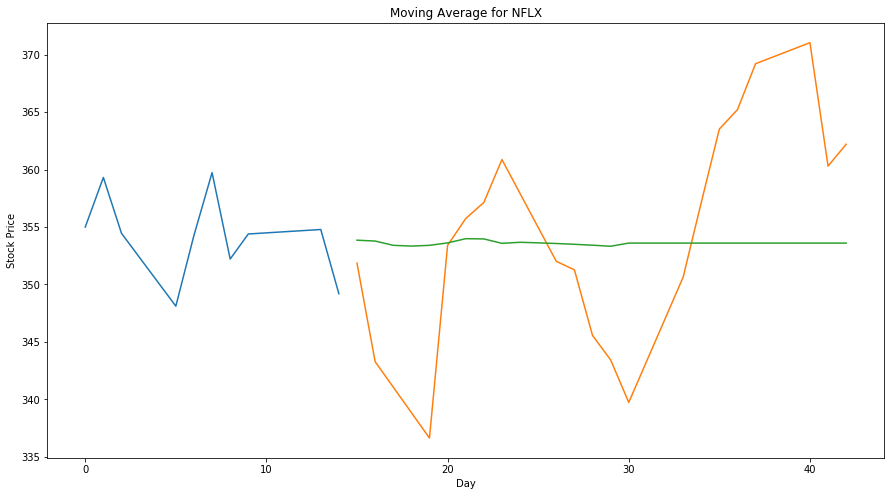

DIS
RMSE: 5.758966167877211 
MAPE: 0.03592767444543219


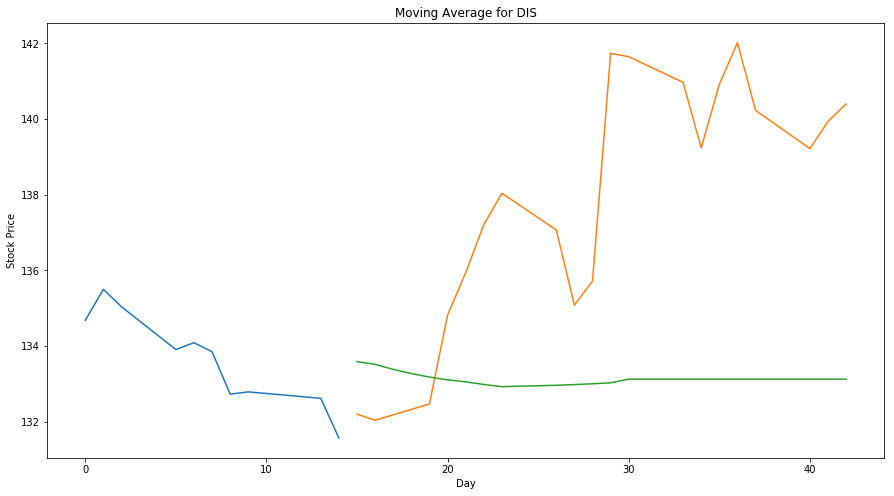

AMZN
RMSE: 68.46197748487891 
MAPE: 0.03268440407101609


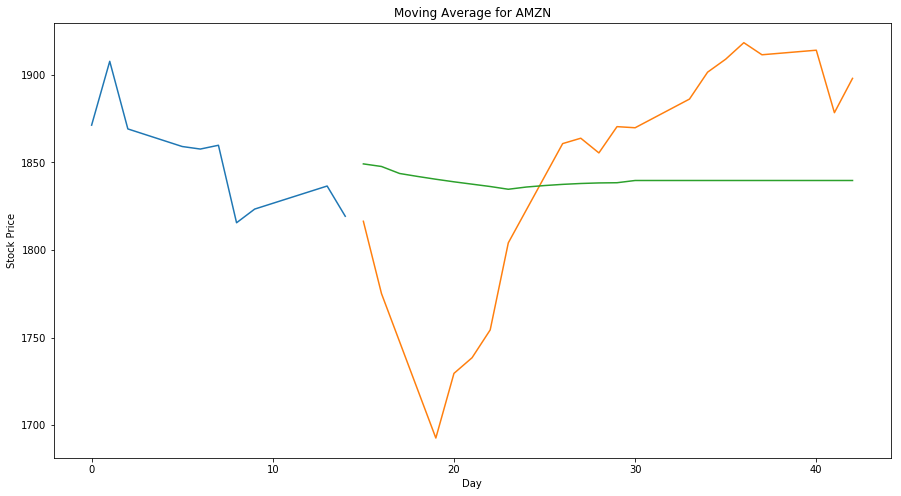

GOOGL
RMSE: 60.88319567020358 
MAPE: 0.05204610275767037


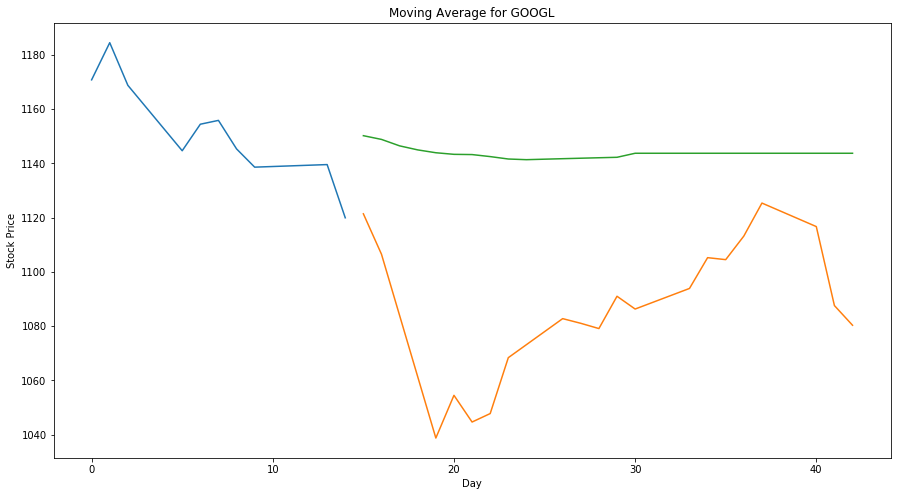

In [115]:
stocks = [netflix_stocks, disney_stocks, amazon_stocks, google_stocks]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0
for stock in stocks:
    df = stock[['date', 'close']]
    train_ma = df[:15]
    valid_ma = df[15:]
    preds = []
    for i in range(0,28):
        a = list(train_ma['close'][i:])
        a.extend(preds)
        preds.append(np.mean(a))
    print(names[j])
    root_mean = np.sqrt(mean_squared_error(valid_ma.close, preds))
    mape = get_mape(valid_ma.close, preds)
    print('RMSE: {} \nMAPE: {}'.format(root_mean, mape))
    plt.plot(train_ma['close'])
    plt.plot(valid_ma[['close', 'Predictions']])
    plt.xlabel('Day')
    plt.ylabel('Stock Price')
    plt.title(f'Moving Average for {names[j]}')
    plt.show()
    j += 1

## Linear Regression: Only Stock Data

NFLX
Cross Validated RMSE: 0.2581433538406095
Cross Validated MAPE: 54.94159876635713
Cross Validated Direction: 44.0


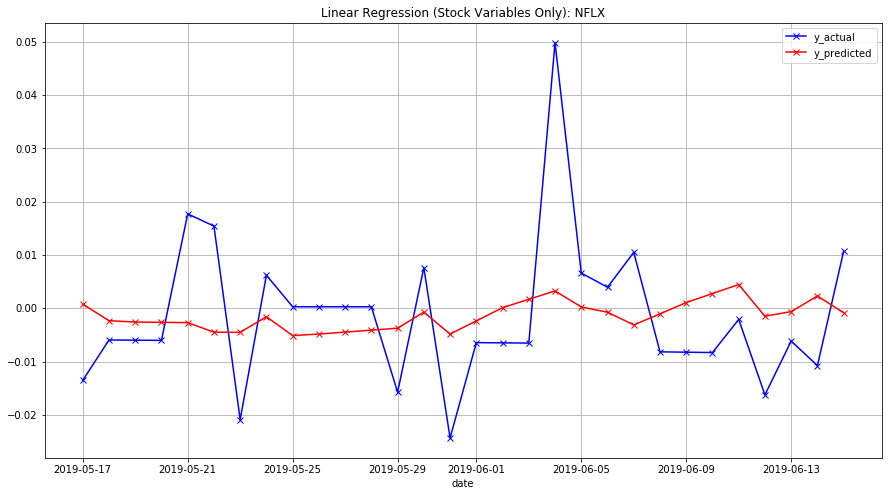

DIS
Cross Validated RMSE: 0.01318810722257992
Cross Validated MAPE: 9.748319797348914
Cross Validated Direction: 44.0


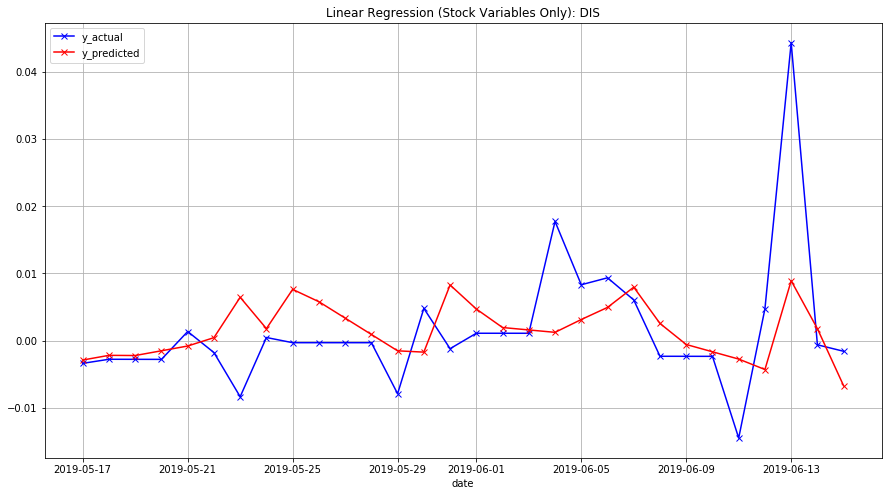

AMZN
Cross Validated RMSE: 0.014982747234611566
Cross Validated MAPE: 3.236854990787606
Cross Validated Direction: 36.0


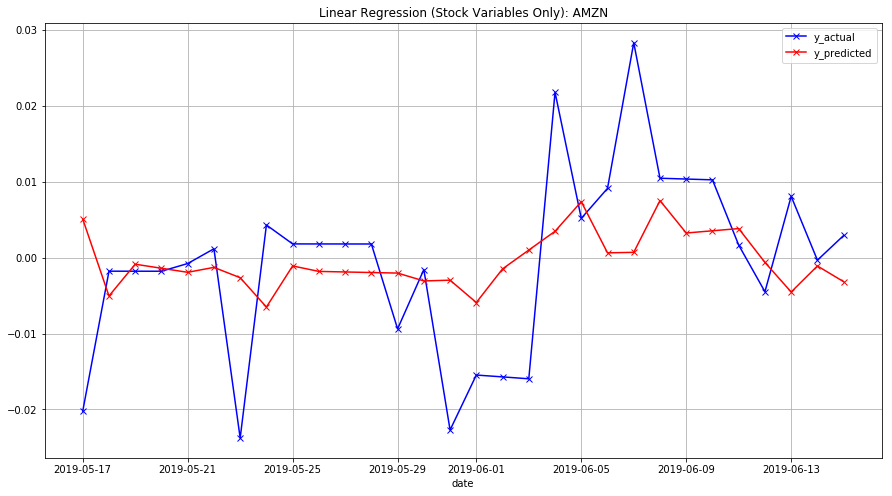

GOOGL
Cross Validated RMSE: 0.02537953752898735
Cross Validated MAPE: 30.70286367050282
Cross Validated Direction: 28.0


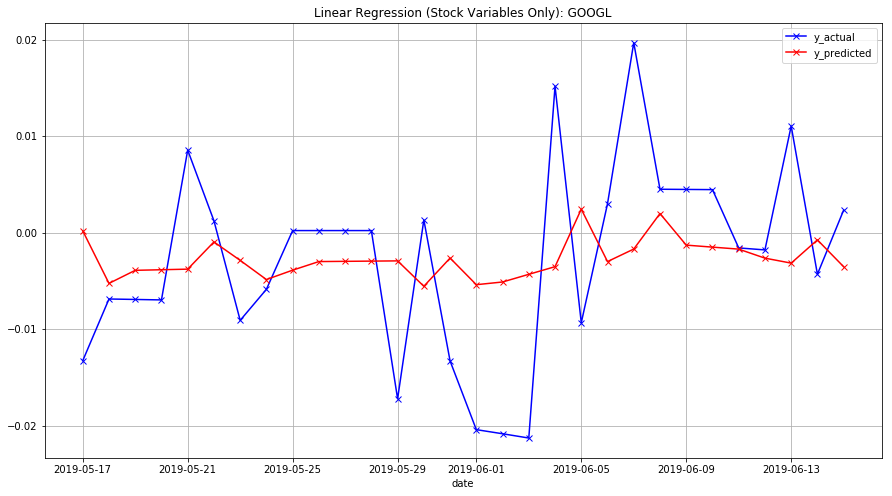

In [91]:
from sklearn.linear_model import LinearRegression
from pylab import rcParams
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data[['volume_l1', 'stock_growth_l1', 'sp_growth']]
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    lm = LinearRegression()
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lm.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Linear Regression (Only Stock)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lm.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Linear Regression (Stock Variables Only): {names[j]}")
    plt.show()
    j += 1

## Linear Regression: Stock Data and Twitter Data

NFLX
Cross Validated RMSE: 0.04026548910066998
Cross Validated MAPE: 32.93178449105124
Cross Validated Direction: 32.0


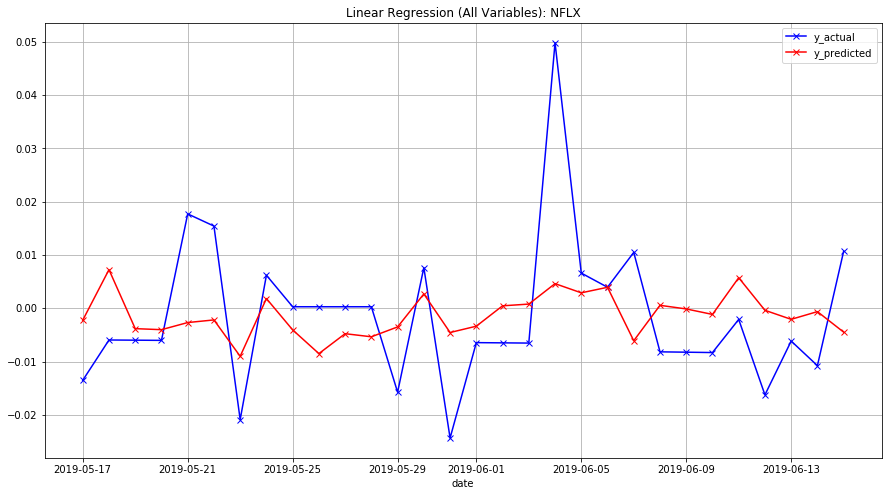

DIS
Cross Validated RMSE: 0.015152597244952876
Cross Validated MAPE: 11.118733611112031
Cross Validated Direction: 36.0


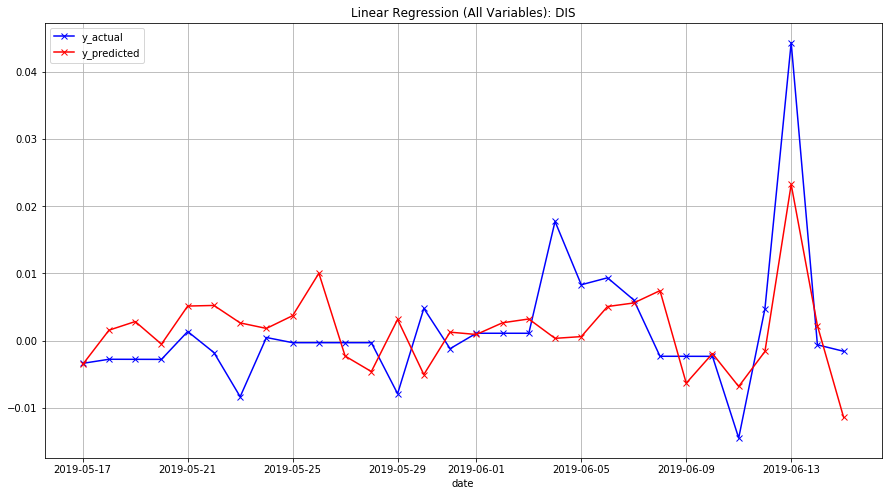

AMZN
Cross Validated RMSE: 0.016406651840533488
Cross Validated MAPE: 3.6280192385952867
Cross Validated Direction: 36.0


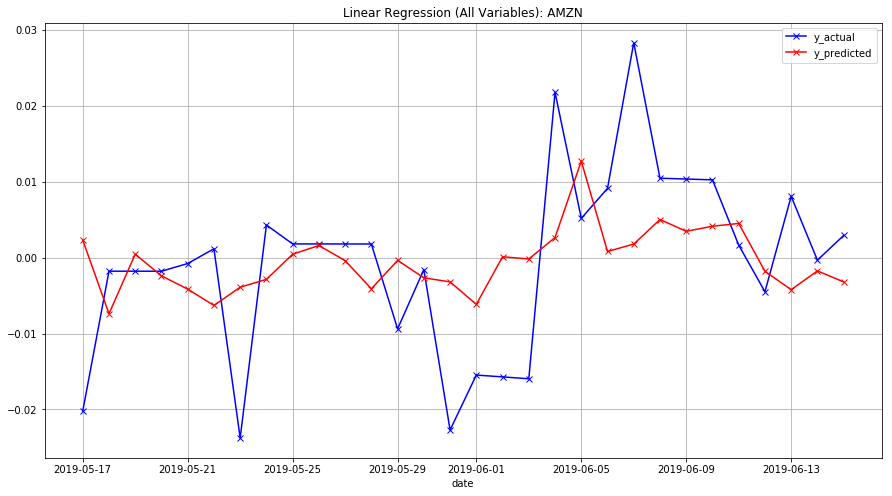

GOOGL
Cross Validated RMSE: 0.023313446282292295
Cross Validated MAPE: 10.140069027212151
Cross Validated Direction: 44.0


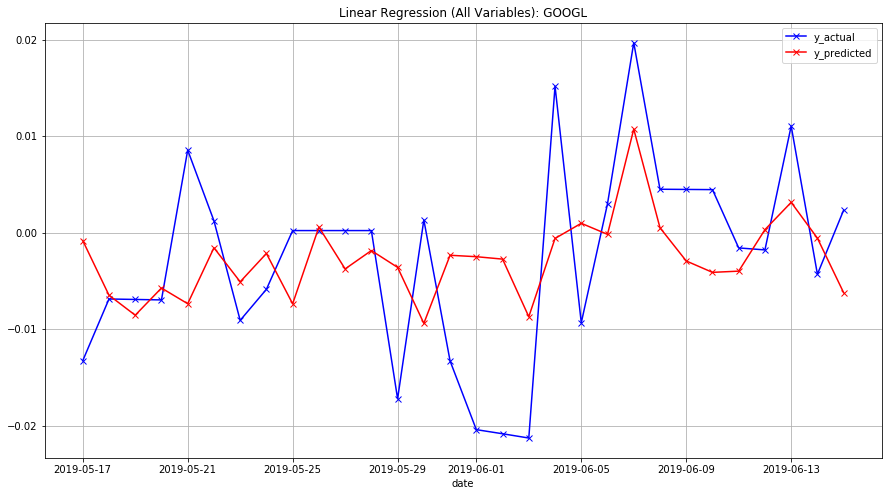

In [92]:
from pylab import rcParams
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    lm = LinearRegression()
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lm.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Linear Regression (All Variables)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lm.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Linear Regression (All Variables): {names[j]}")
    plt.show()
    j += 1

RMSE: 0.014656829307157457
MAPE: 1.933527679806581
Direction: 36.36363636363637


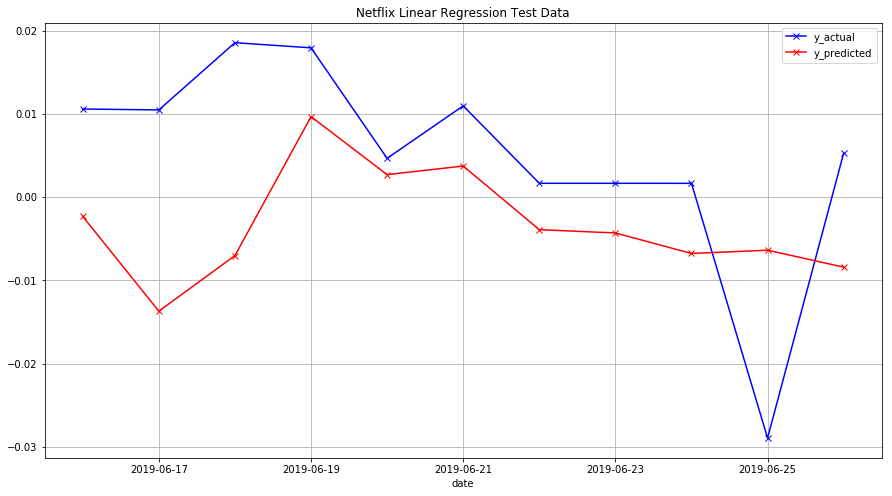

In [60]:
X = netflix_train.drop(['date', 'stock_growth', 'close'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
lr = LinearRegression()
model = lr.fit(X, y)
y_results['predictions'] = model.predict(disney_test.drop(['date', 'stock_growth', 'close'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Netflix Linear Regression Test Data')
plt.show()

In [55]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df.sort_values('Coefficient', ascending = False)

,Coefficient
sp_growth,0.715679
percent_neg,0.063416
percent_pos,0.024997
w_avg_sent,0.008032
volume_l1,0.002506
stock_growth_l1,-0.305140


## Ridge Regression: Stock Data and Twitter Data

NFLX
Cross Validated RMSE: 0.015533257778079169
Cross Validated MAPE: 2.339612473595402
Cross Validated Direction: 48.0


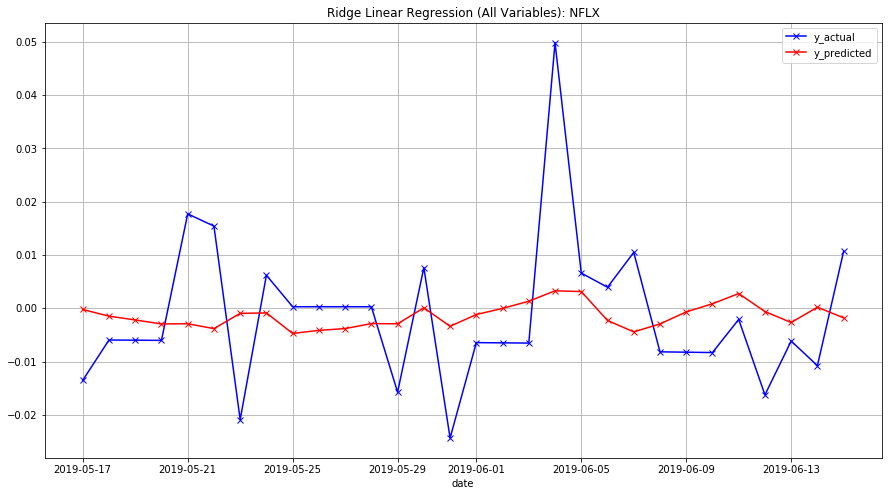

DIS
Cross Validated RMSE: 0.008933657071029551
Cross Validated MAPE: 1.9388776218782986
Cross Validated Direction: 48.0


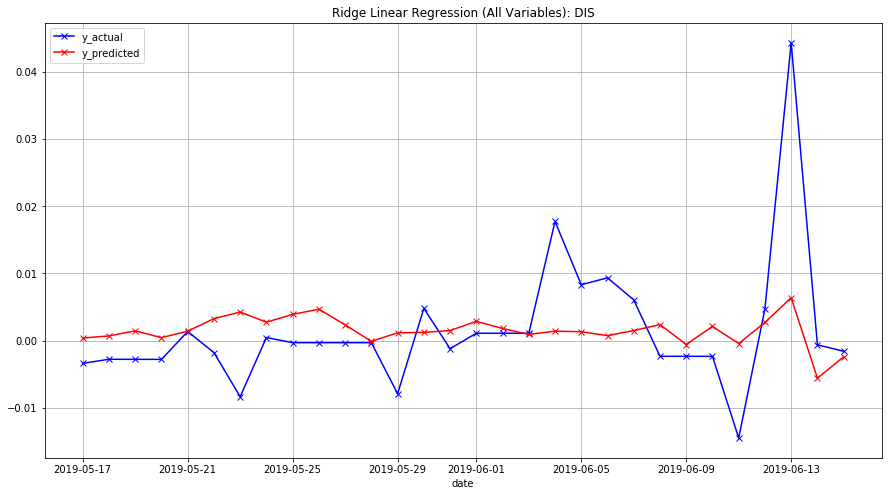

AMZN
Cross Validated RMSE: 0.012461199331253012
Cross Validated MAPE: 2.1398774459640646
Cross Validated Direction: 40.0


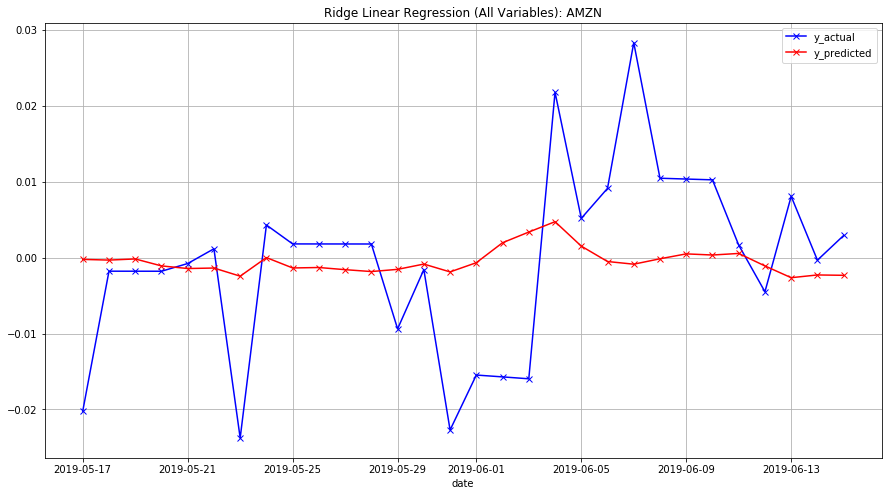

GOOGL
Cross Validated RMSE: 0.010155576384513176
Cross Validated MAPE: 4.082837528234598
Cross Validated Direction: 44.0


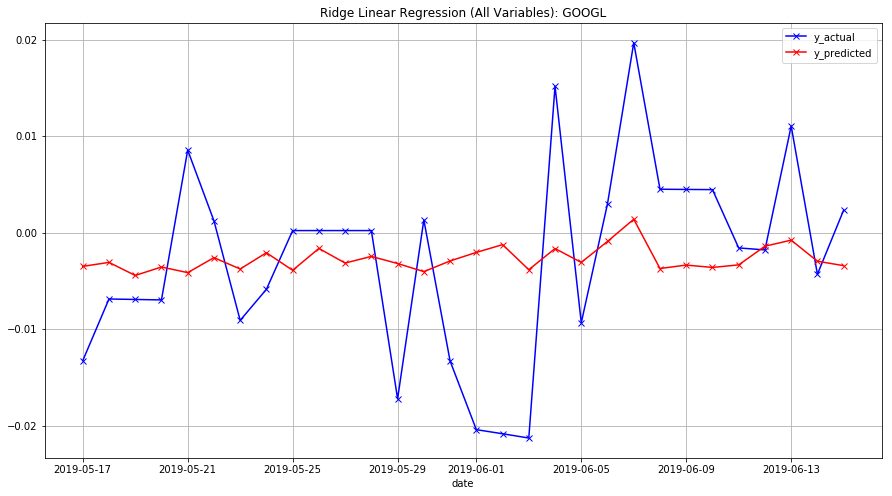

In [63]:
from sklearn.linear_model import Ridge
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    lm = Ridge()
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lm.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Ridge Regression (All Variables)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lm.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Ridge Linear Regression (All Variables): {names[j]}")
    plt.show()
    j += 1

In [68]:
X = netflix_train.drop(['date','close', 'stock_growth'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
lm = Ridge()
model = lm.fit(X, y)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df.sort_values('Coefficient', ascending = False)

,Coefficient
percent_neg,0.003859
volume_l1,0.001878
sp_growth,0.000041
stock_growth_l1,-0.000212
w_avg_sent,-0.000920
percent_pos,-0.001534


## Lasso Regression: Stock Data and Twitter Data

NFLX
Cross Validated RMSE: 0.014811911708507925
Cross Validated MAPE: 2.283325212707274
Cross Validated Direction: 52.0


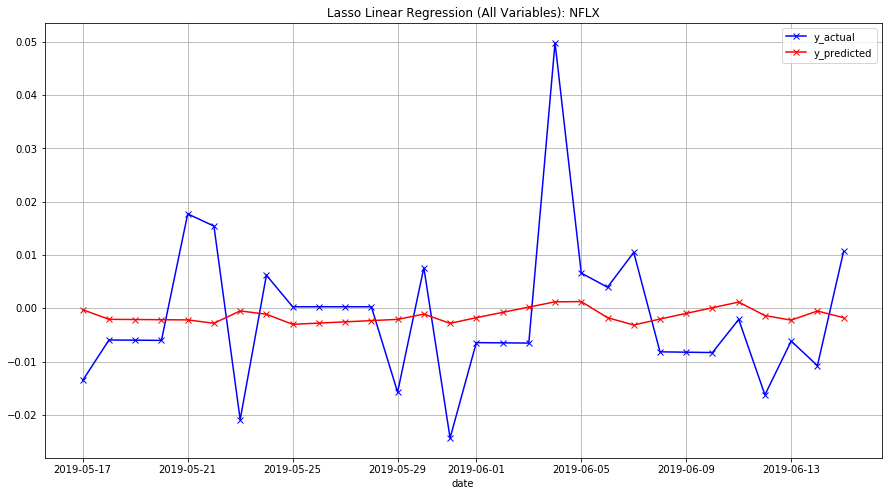

DIS
Cross Validated RMSE: 0.008711274032835692
Cross Validated MAPE: 2.141779497593271
Cross Validated Direction: 48.0


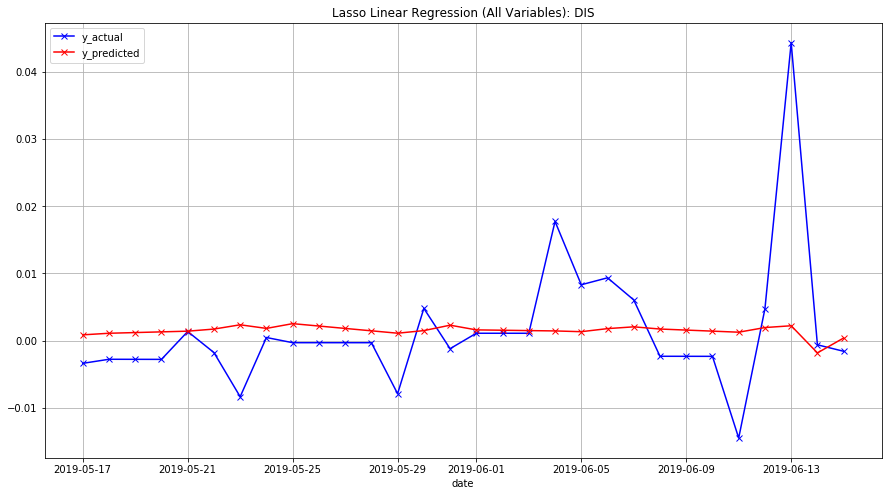

AMZN
Cross Validated RMSE: 0.012255385693981317
Cross Validated MAPE: 2.0007751871134185
Cross Validated Direction: 40.0


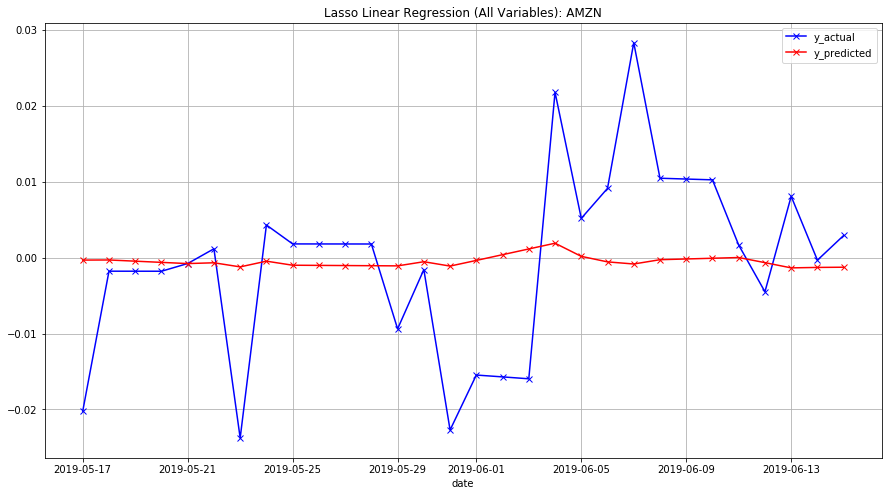

GOOGL
Cross Validated RMSE: 0.010068724203131808
Cross Validated MAPE: 4.585540269912824
Cross Validated Direction: 44.0


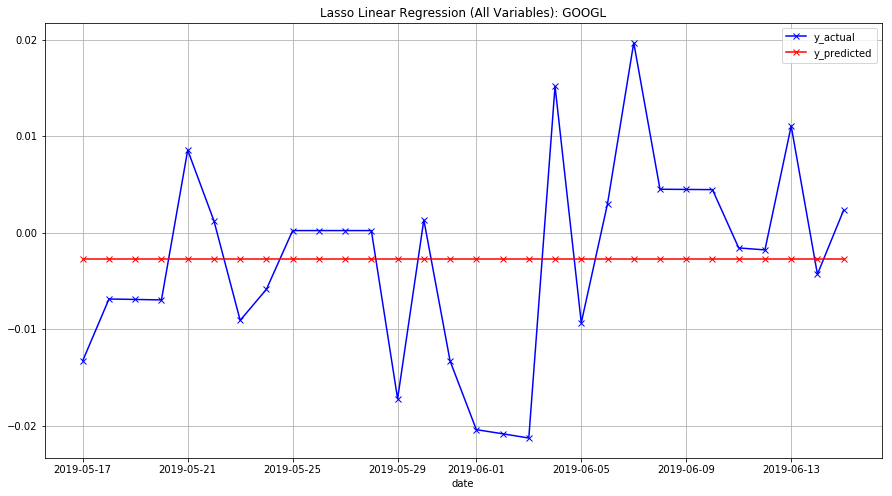

In [62]:
from sklearn.linear_model import Lasso
from pylab import rcParams
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    lm = Lasso(alpha = 0.001)
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lm.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Lasso Regression (All Variables, Alpha 0.001)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lm.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Lasso Linear Regression (All Variables): {names[j]}")
    plt.show()
    j += 1

In [71]:
X = netflix_train.drop(['date','close', 'stock_growth'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
lm =Lasso(alpha = 0.001)
model = lm.fit(X, y)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df.sort_values('Coefficient', ascending = False)

,Coefficient
volume_l1,0.001141
stock_growth_l1,-0.000000
sp_growth,0.000000
w_avg_sent,-0.000000
percent_neg,0.000000
percent_pos,-0.000000


In [93]:
final_scores[~final_scores["Algorithm"].str.contains('Polynomial')].groupby('Algorithm').mean().sort_values('RMSE')

,RMSE,MAPE,Direction
Algorithm,,,
Linear Regression (All Variables),0.023785,14.454652,37.0
Linear Regression (Only Stock),0.077923,24.657409,38.0


RMSE: 0.013530527956918574
MAPE: 1.0962539788443129
Direction: 18.181818181818183


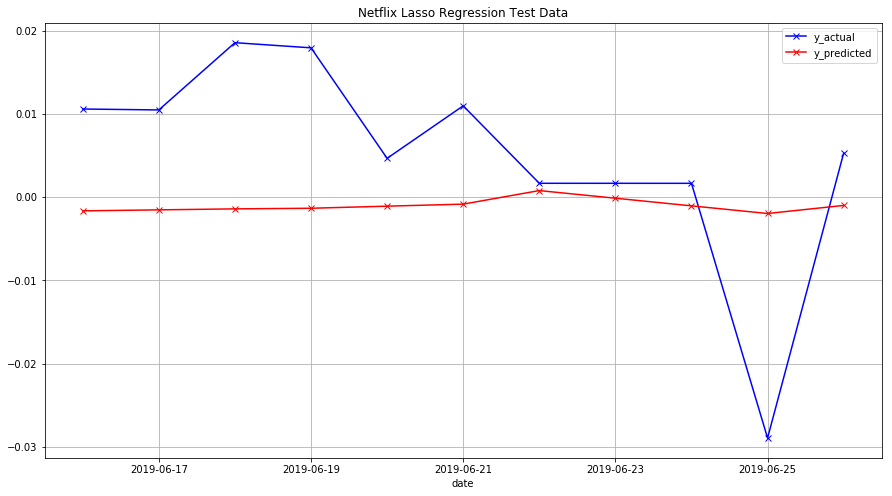

In [70]:
X = netflix_train.drop(['date','close', 'stock_growth'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
lm =Lasso(alpha = 0.001)
model = lm.fit(X, y)
y_results['predictions'] = model.predict(netflix_test.drop(['date','close','stock_growth'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Netflix Lasso Regression Test Data')
plt.show()

## Diving Deeper into Linear Regression Model

As illustrated by the graph below, the relationship between between stock percentage change and weighted compound sentiment value is non linear. Introducing polynomial variables may improve the model.

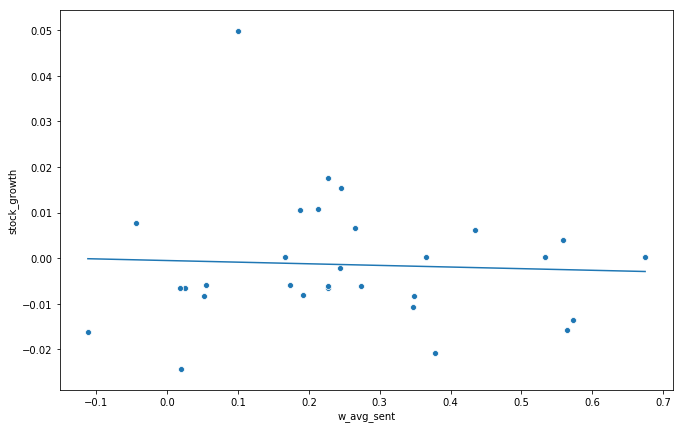

In [72]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 7))
sns.scatterplot(x='w_avg_sent', y='stock_growth', data = netflix_train, ax=ax)
lm = LinearRegression()
x = netflix_train[['w_avg_sent']].values
y = netflix_train['stock_growth'].values
model = lm.fit(x, y)
y_pred = model.predict(x)
lin_results = netflix_train[['w_avg_sent']]
lin_results['y_pred'] = y_pred
sns.lineplot(x='w_avg_sent', y='y_pred', data = lin_results, ax = ax)
plt.ylabel('stock_growth')
plt.show()

Text(0, 0.5, 'y')

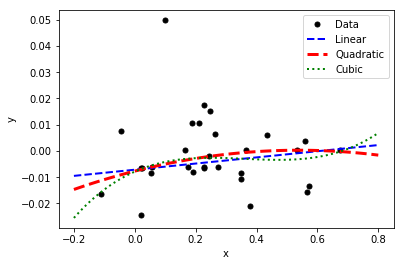

In [402]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xm = netflix_train[['w_avg_sent']].values
ym = netflix_train['stock_growth'].values

#### Solution
m = GEKKO()
m.options.IMODE=2
# coefficients
c = [m.FV(value=0) for i in range(4)]
x = m.Param(value=xm)
y = m.CV(value=ym)
y.FSTATUS = 1
# polynomial model
m.Equation(y==c[0]+c[1]*x+c[2]*x**2+c[3]*x**3)

# linear regression
c[0].STATUS=1
c[1].STATUS=1
m.solve(disp=False)
p1 = [c[1].value[0],c[0].value[0]]

# quadratic
c[2].STATUS=1
m.solve(disp=False)
p2 = [c[2].value[0],c[1].value[0],c[0].value[0]]

# cubic
c[3].STATUS=1
m.solve(disp=False)
p3 = [c[3].value[0],c[2].value[0],c[1].value[0],c[0].value[0]]

# plot fit
plt.plot(xm,ym,'ko',markersize=5)
xp = np.linspace(-0.2,0.8,100)
plt.plot(xp,np.polyval(p1,xp),'b--',linewidth=2)
plt.plot(xp,np.polyval(p2,xp),'r--',linewidth=3)
plt.plot(xp,np.polyval(p3,xp),'g:',linewidth=2)
plt.legend(['Data','Linear','Quadratic','Cubic'],loc='best')
plt.xlabel('x')
plt.ylabel('y')

To see which Polynomial degree would fit best, I will run a polynomial regession of degrees ranging from 1 to 5 to see which is the best.

In [95]:
from sklearn.linear_model import LinearRegression
metrics = pd.DataFrame(columns=['company','degree', 'RMSE', 'MAPE', 'Direction'])
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    for degree in range(1,6):
        pipeline = Pipeline([("polyfit", PolynomialFeatures(degree)),
                        ("lr", Ridge())])
        index = 1
        RMSE = []
        MAPE = []
        Direction = []
        for train_index, test_index in splits.split(X):
            x_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            x_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            model = pipeline.fit(x_train, y_train)
            preds = model.predict(x_test)
            RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
            MAPE.append(get_mape(y_test, preds))
            Direction.append(get_direction(y_test, preds))
            index += 1
        metrics = metrics.append({'company': names[j], 'degree': degree, 'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    j += 1

In [132]:
metrics.groupby('degree').mean().sort_values('RMSE')

,RMSE,MAPE,Direction
degree,,,
1,0.011771,2.625301,45.0
3,0.013650,4.391348,47.0
2,0.016123,3.949842,50.0
4,0.038442,5.616052,45.0
5,0.041245,12.296007,44.0


Although degree 1 does best in terms of RMSE, I will choose to build a model using polynomial regressions of degree 3 since it has a good trade off between RMSE and direction. I will not be using MAPE as the deciding metric since it measures the size of error in percentage terms. When deciding when to buy a stock, we care about the magnitude in the stock growth value and the direction; therefore, we use RMSE since we want as close to the true target value as possible and direction accuracy since we want to know whether to buy or sell.

## Polynomial Linear Regression

NFLX
Cross Validated RMSE: 0.10649519594679258
Cross Validated MAPE: 79.80030597429811
Cross Validated Direction: 52.0


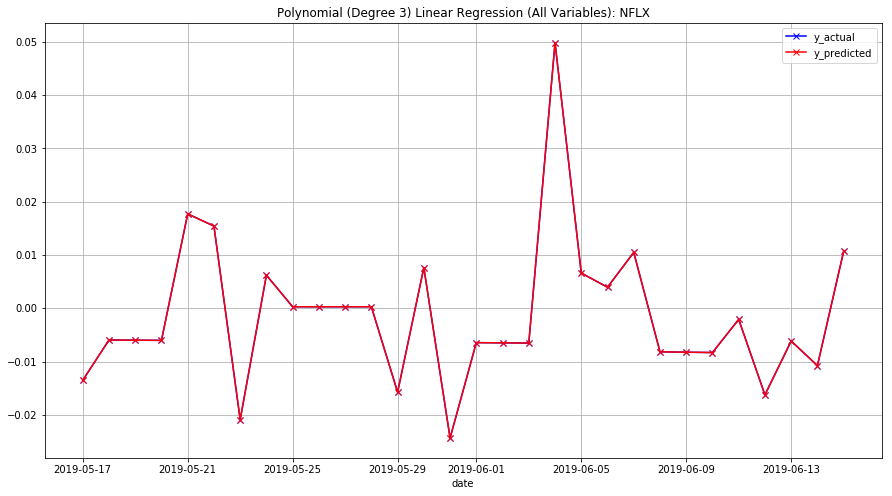

DIS
Cross Validated RMSE: 0.23699451750212502
Cross Validated MAPE: 202.88110308855755
Cross Validated Direction: 40.0


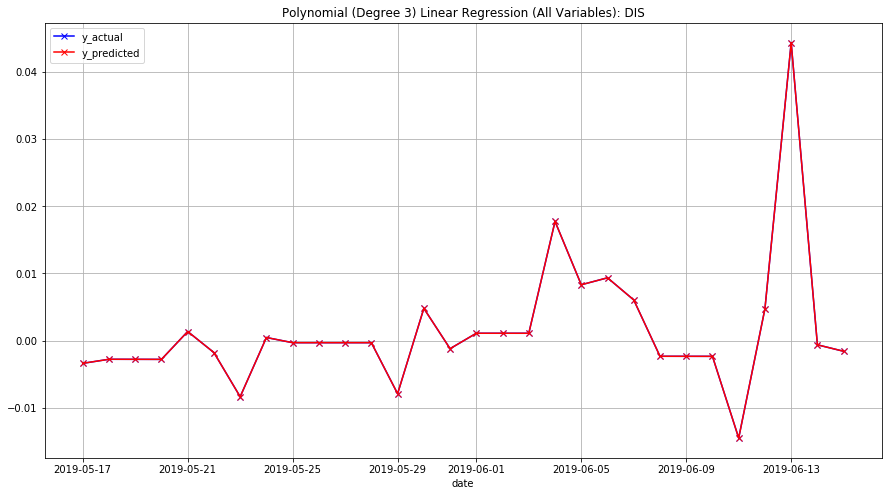

AMZN
Cross Validated RMSE: 1.2287854376809997
Cross Validated MAPE: 66.05465841170812
Cross Validated Direction: 44.0


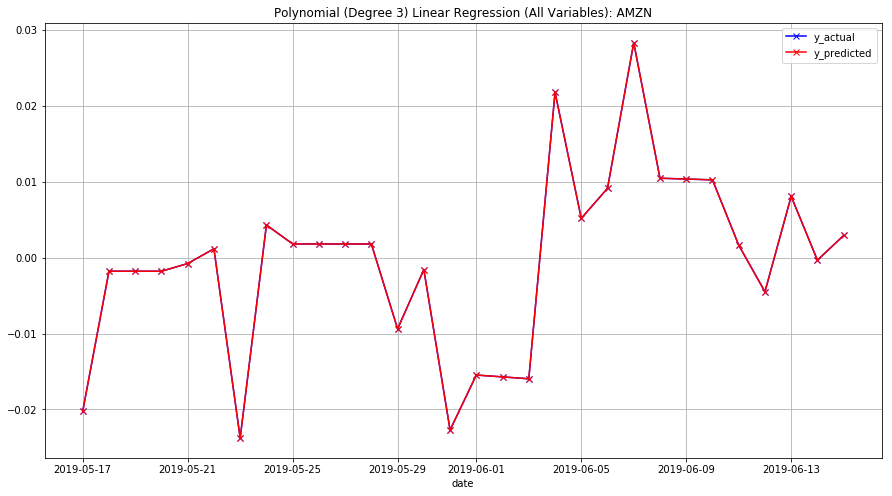

GOOGL
Cross Validated RMSE: 2.8952304226628156
Cross Validated MAPE: 164.11547779739226
Cross Validated Direction: 36.0


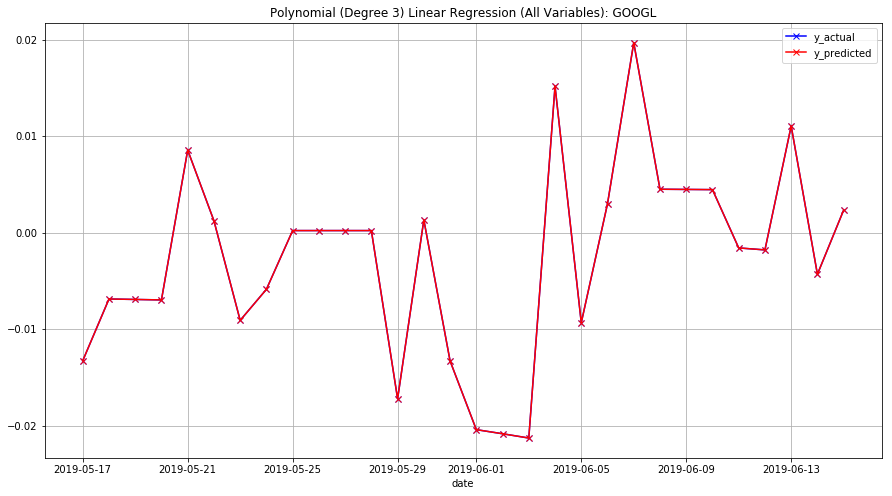

In [96]:
from sklearn.pipeline import Pipeline
# Import function to automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression

train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", LinearRegression())])
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = pipeline.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Polynomial Regression (Degree of 3)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = pipeline.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Polynomial (Degree 3) Linear Regression (All Variables): {names[j]}")
    plt.show()
    j += 1

### Test Data Performance

RMSE: 0.049463874003573126
MAPE: 9.801759268038309
Direction: 72.72727272727273


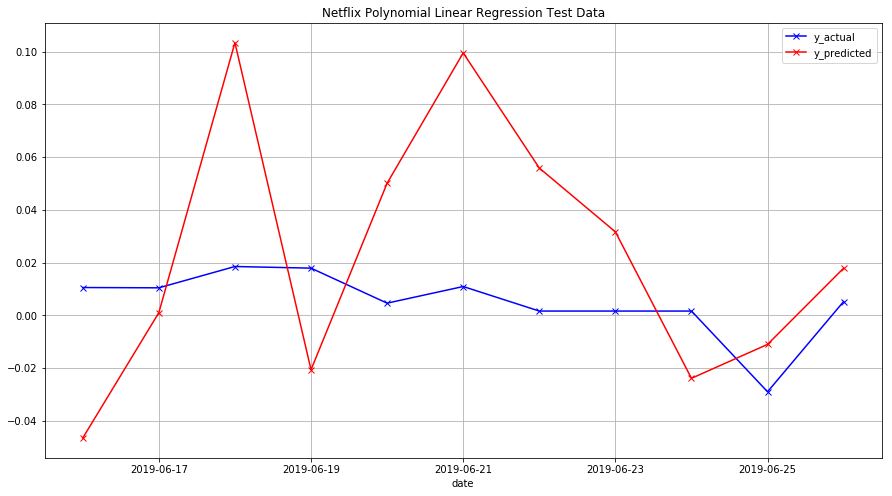

In [364]:
X = netflix_train.drop(['date','close', 'stock_l1', 'stock_growth'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", LinearRegression())])
model = pipeline.fit(X, y)
y_results['predictions'] = model.predict(netflix_test.drop(['date','close','stock_l1','stock_growth'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Netflix Polynomial Linear Regression Test Data')
plt.show()

RMSE: 0.13343520640116305
MAPE: 34.14472734493351
Direction: 90.9090909090909


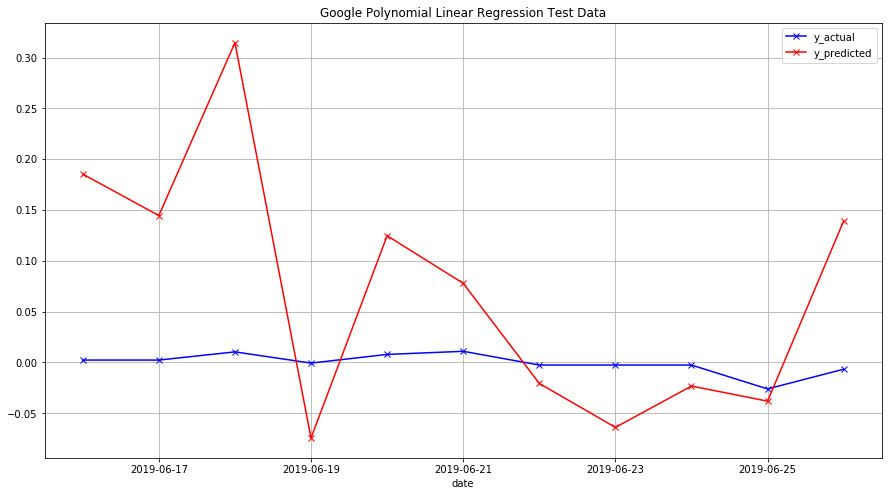

In [61]:
X = google_train.drop(['date','close', 'stock_l1', 'stock_growth'], 1)
y = google_train['stock_growth']
y_results = google_test[['date', 'stock_growth']]
pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", LinearRegression())])
model = pipeline.fit(X, y)
y_results['predictions'] = model.predict(netflix_test.drop(['date','close','stock_l1','stock_growth'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Google Polynomial Linear Regression Test Data')
plt.show()

## Polynomial Ridge Linear Regression

NFLX
Cross Validated RMSE: 0.02140127770906295
Cross Validated MAPE: 5.495614667188474
Cross Validated Direction: 60.0


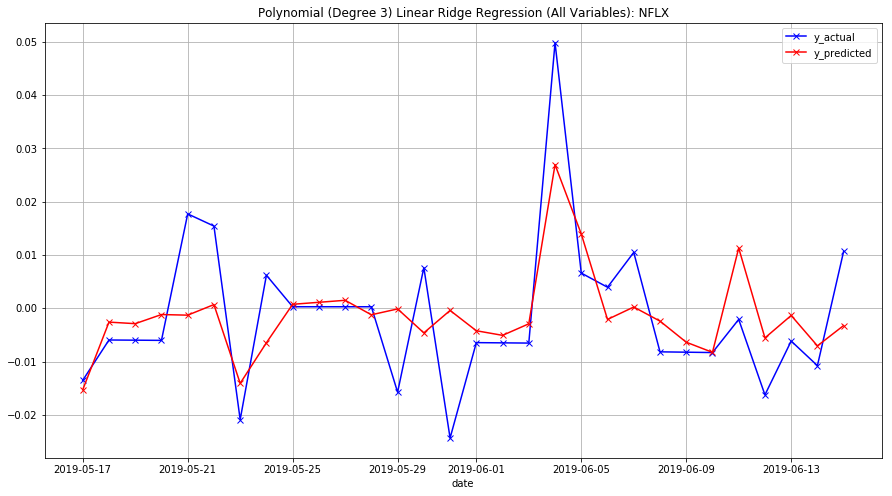

DIS
Cross Validated RMSE: 0.009713778364064323
Cross Validated MAPE: 3.9063550677405368
Cross Validated Direction: 48.0


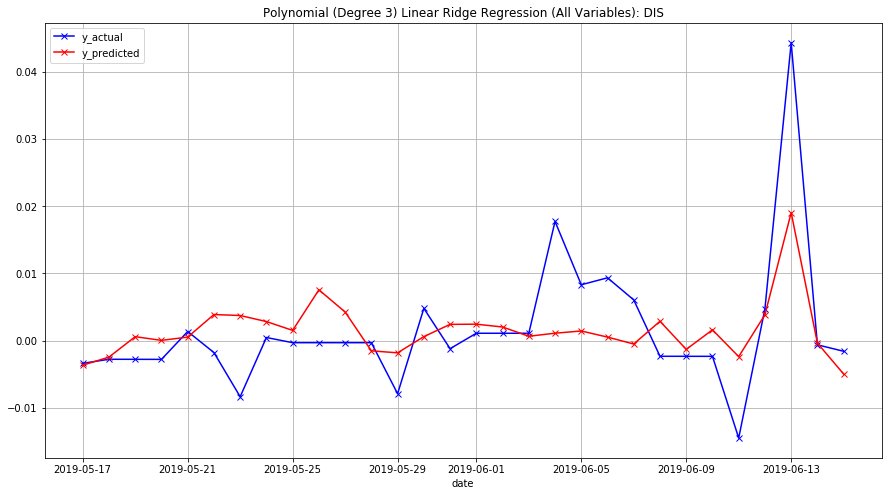

AMZN
Cross Validated RMSE: 0.012995980810156566
Cross Validated MAPE: 3.865510741053839
Cross Validated Direction: 36.0


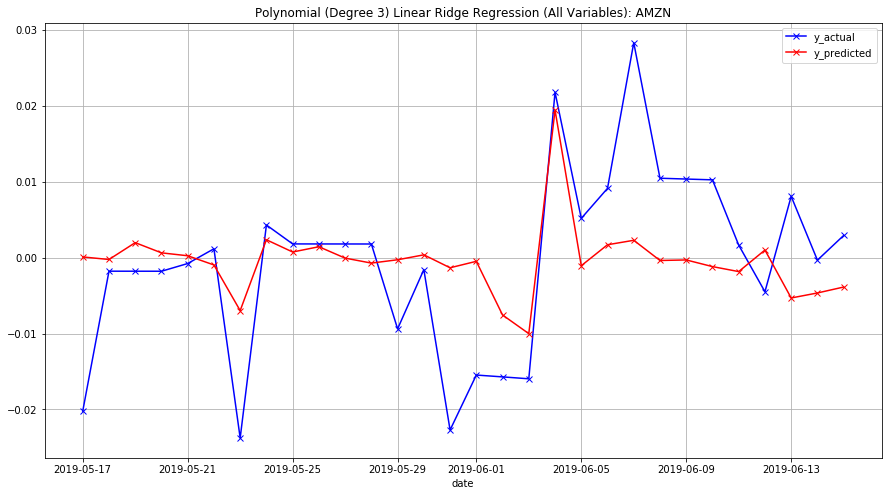

GOOGL
Cross Validated RMSE: 0.010487244655761457
Cross Validated MAPE: 4.297910758774366
Cross Validated Direction: 44.0


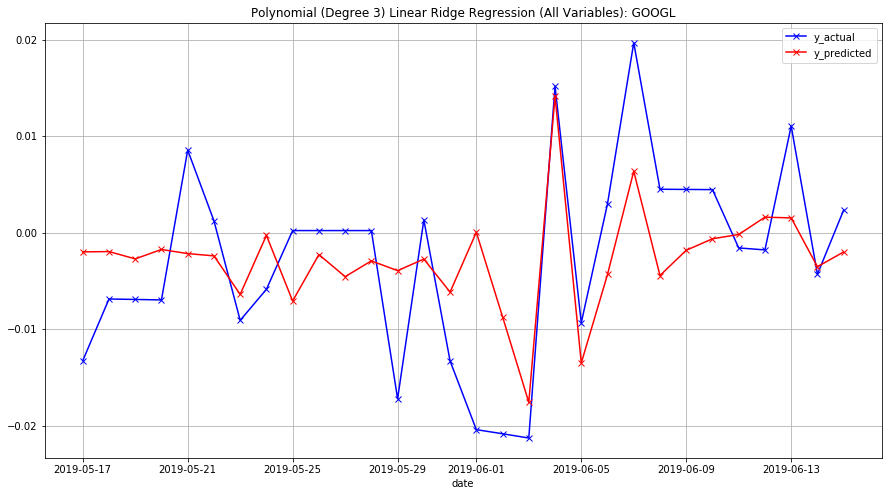

In [98]:
from sklearn.linear_model import Ridge
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", Ridge())])
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = pipeline.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Polynomial Ridge Regression (Degree of 3)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = pipeline.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Polynomial (Degree 3) Linear Ridge Regression (All Variables): {names[j]}")
    plt.show()
    j += 1

## Polynomial Lasso Linear Regression

NFLX
Cross Validated RMSE: 0.015139743735684288
Cross Validated MAPE: 2.619798517638474
Cross Validated Direction: 64.0


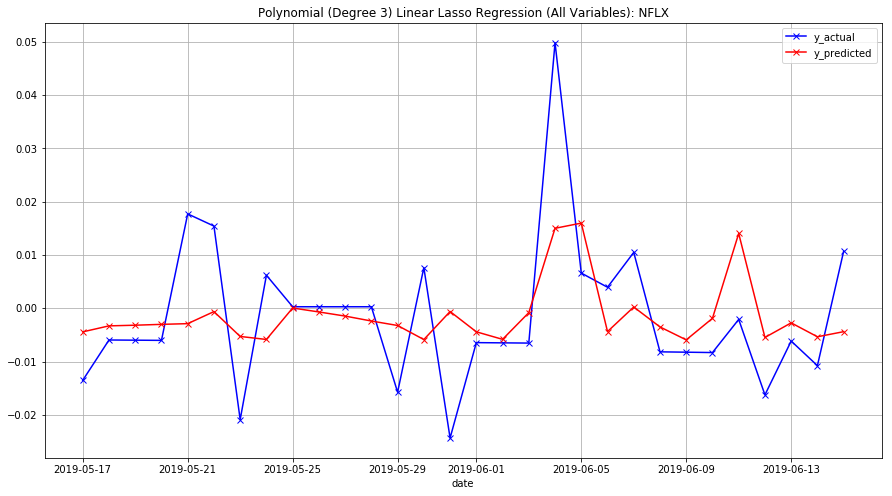

DIS
Cross Validated RMSE: 0.008717265276978239
Cross Validated MAPE: 2.1457383042097584
Cross Validated Direction: 48.0


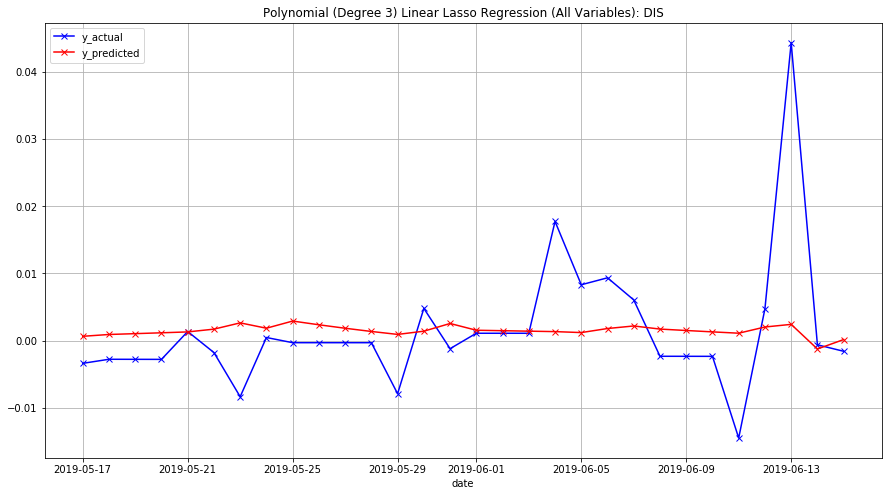

AMZN
Cross Validated RMSE: 0.016008709044651712
Cross Validated MAPE: 2.809316492279712
Cross Validated Direction: 32.0


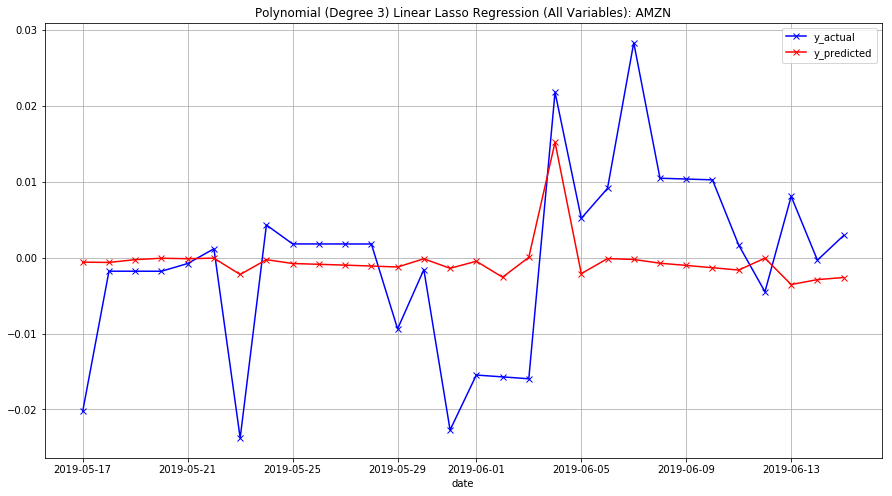

GOOGL
Cross Validated RMSE: 0.010576673922412077
Cross Validated MAPE: 4.680169686397126
Cross Validated Direction: 44.0


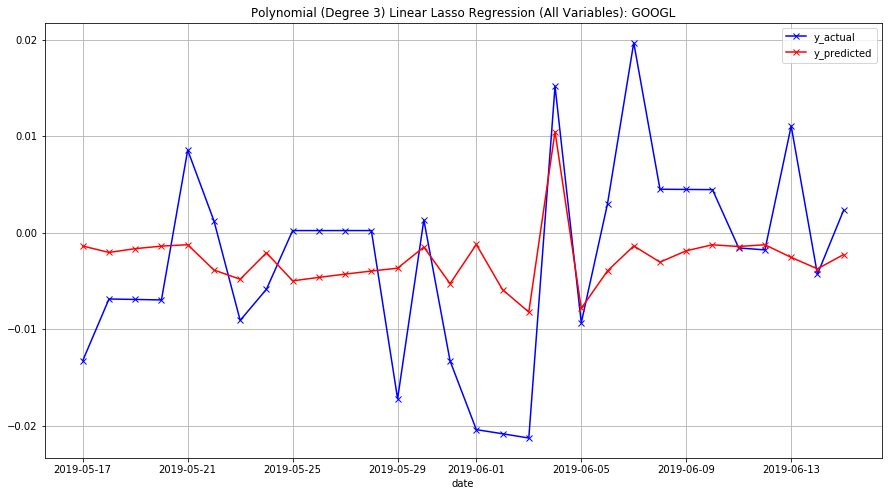

In [99]:
from sklearn.linear_model import Lasso
train_data = [netflix_train, disney_train, amazon_train, google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in train_data:
    X = data.drop(['date','close', 'stock_growth'], 1)
    y = data['stock_growth']
    splits = TimeSeriesSplit(n_splits=5)
    pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", Lasso(alpha=0.001))])
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = pipeline.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Polynomial Lasso Regression (Degree of 3, Alpha 0.001)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    
    model = pipeline.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Polynomial (Degree 3) Linear Lasso Regression (All Variables): {names[j]}")
    plt.show()
    j += 1

In [100]:
final_scores[final_scores["Algorithm"].str.contains('Polynomial')].groupby('Algorithm').mean().sort_values('RMSE')

,RMSE,MAPE,Direction
Algorithm,,,
"Polynomial Lasso Regression (Degree of 3, Alpha 0.001)",0.012611,3.063756,47.0
Polynomial Ridge Regression (Degree of 3),0.013650,4.391348,47.0
Polynomial Regression (Degree of 3),1.116876,128.212886,43.0


### Test Data

RMSE: 0.016152988988431267
MAPE: 2.10253943369575
Direction: 18.181818181818183


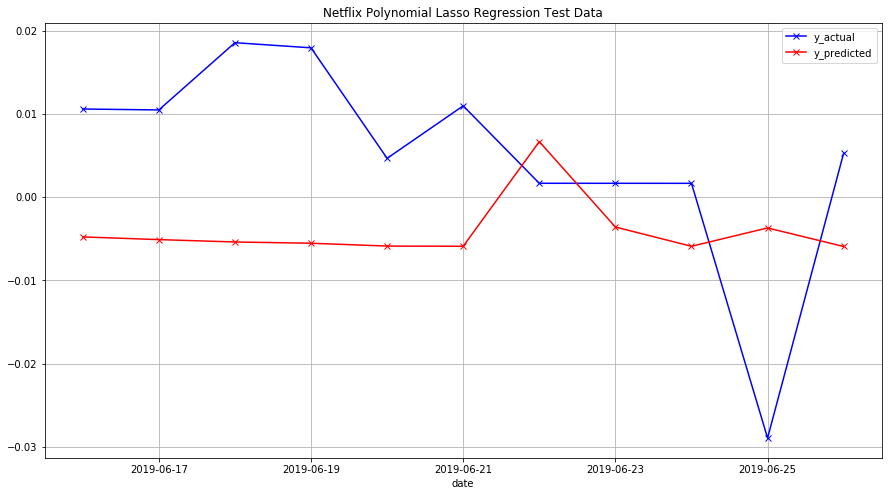

In [106]:
X = netflix_train.drop(['date','close', 'stock_growth'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", Lasso(alpha=0.001))])
model = pipeline.fit(X, y)
y_results['predictions'] = model.predict(netflix_test.drop(['date','close','stock_growth'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Netflix Polynomial Lasso Regression Test Data')
plt.show()

In [89]:
X = netflix_train.drop(['date','close', 'stock_growth'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", Lasso(alpha=0.001))])
model = pipeline.fit(X, y)
(model.named_steps['lr'].coef_)

array([ 0.        , -0.00190509, -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.00281842, -0.        , -0.        ,
       -0.00014053,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.00109968, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

RMSE: 0.009687018425963317
MAPE: 1.1943244209554063
Direction: 54.54545454545454


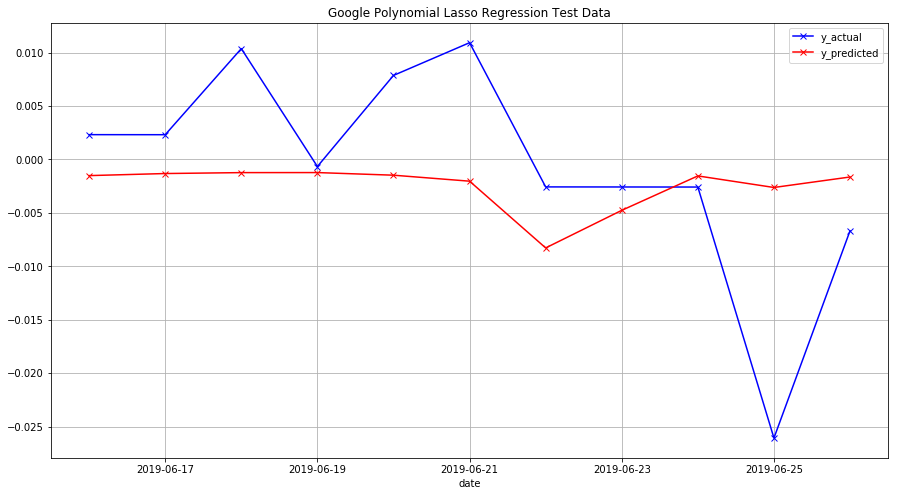

In [103]:
X = google_train.drop(['date','close', 'stock_growth'], 1)
y = google_train['stock_growth']
y_results = google_test[['date', 'stock_growth']]
pipeline = Pipeline([("polyfit", PolynomialFeatures(degree=3)),
                        ("lr", Lasso(alpha=0.001))])
model = pipeline.fit(X, y)
y_results['predictions'] = model.predict(netflix_test.drop(['date','close','stock_growth'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Google Polynomial Lasso Regression Test Data')
plt.show()

In [107]:
final_scores.groupby('Algorithm').mean().sort_values('RMSE')

,RMSE,MAPE,Direction
Algorithm,,,
"Polynomial Lasso Regression (Degree of 3, Alpha 0.001)",0.012611,3.063756,47.0
Polynomial Ridge Regression (Degree of 3),0.013650,4.391348,47.0
Linear Regression (All Variables),0.023785,14.454652,37.0
Linear Regression (Only Stock),0.077923,24.657409,38.0
Polynomial Regression (Degree of 3),1.116876,128.212886,43.0


The model does not seem to have been able to anticipate that the huge drop on 6/25/2019. I will explore another model which may capture the relationship better.

### Weighted Moving Average Model

In the weighted moving average model, I will run a linear regression on historical stock growth and sentiment value data. The model will determine the value of the weights given to each variable.

For example, if I am running the model with a 3 day lag, the model will be trained on the stock growth and the sentiment value for the past 3 days.

In [190]:
# Set up data
netflix_stocks_train = netflix_stocks[:32]
netflix_tweet_train = netflix_tweet[:32]
disney_stocks_train = disney_stocks[:32]
disney_tweet_train = disney_tweet[:32]
amazon_stocks_train = amazon_stocks[:32]
amazon_tweet_train = amazon_tweet[:32]
google_stocks_train = google_stocks[:32]
google_tweet_train = google_tweet[:32]

In [196]:
metrics = pd.DataFrame(columns=['company','num_lag', 'RMSE', 'MAPE', 'Direction'])
train_data = [[netflix_stocks_train, netflix_tweet_train], [disney_stocks_train, disney_tweet_train], [amazon_stocks_train, amazon_tweet_train], [google_stocks_train, google_tweet_train]]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for stock_data, tweet_data in train_data:
    temp_stock_data = stock_data[['date', 'close']]
    temp_tweet_data = tweet_data[['w_avg_sent']]
    splits = TimeSeriesSplit(n_splits=5)
    temp_stock_data['stock_growth'] = (stock_data.close - stock_data.close.shift(1))/stock_data.close.shift(1)
    for lag in range(2,7):
        for day in range(1, lag+1):
            stock = 'stock_growth_l' + str(day)
            temp_stock_data[stock] = temp_stock_data.stock_growth.shift(day)
            tweet = 'w_avg_sent_l' + str(day)
            temp_tweet_data[tweet] = tweet_data.w_avg_sent.shift(day)
        temp_tweet_data['tmp'] = np.arange(1, len(temp_tweet_data)+1)
        temp_stock_data['tmp'] = np.arange(1, len(temp_stock_data)+1)
        df_merge = temp_stock_data.merge(temp_tweet_data, on = 'tmp')
        df_merge = df_merge.drop(['close','tmp', 'w_avg_sent'], axis = 1).dropna()
        df_merge
        y = df_merge['stock_growth']
        X = df_merge.drop(['date', 'stock_growth'], axis=1)
        lr = LinearRegression()
        index = 1
        RMSE = []
        MAPE = []
        Direction = []
        for train_index, test_index in splits.split(X):
            x_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            x_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            model = lr.fit(x_train, y_train)
            preds = model.predict(x_test)
            RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
            MAPE.append(get_mape(y_test, preds))
            Direction.append(get_direction(y_test, preds))
            index += 1
        metrics = metrics.append({'company': names[j], 'num_lag': lag, 'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    j += 1
metrics

,company,num_lag,RMSE,MAPE,Direction
0,NFLX,2,0.015743,5.068531,25.0
1,NFLX,3,0.017684,9.912616,50.0
2,NFLX,4,0.025053,12.888309,60.0
3,NFLX,5,0.036456,36.541588,40.0
4,NFLX,6,0.039413,7.728725,55.0
5,DIS,2,0.012208,3.574975,25.0
6,DIS,3,0.013329,3.962521,25.0
7,DIS,4,0.013408,6.135405,20.0
8,DIS,5,0.025734,11.009630,25.0
9,DIS,6,0.029709,10.017050,35.0


In [197]:
metrics.groupby('num_lag').mean().sort_values('RMSE')

,RMSE,MAPE,Direction
num_lag,,,
2,0.013601,3.344651,27.5
3,0.018356,9.122689,40.0
4,0.019183,9.706843,40.0
5,0.027651,15.160685,37.5
6,0.031568,8.415162,45.0


It looks like the model with the 2 day lag had the best RMSE score; however, it did horrible in terms of direction. The variables seem to be given too high of a weight in the model. The model with the 3 day lag, on the other hand, did well in terms of both RMSE and  direction. I will choose build a model with a 3 day lag to represent the weighted moving average algorithm.

In [108]:
temp_stock_data = netflix_stocks[['date', 'close']]
temp_tweet_data = netflix_tweet[['w_avg_sent']]
temp_stock_data['stock_growth'] = (temp_stock_data.close - temp_stock_data.close.shift(1))/temp_stock_data.close.shift(1)
for day in range(1, 4):
    stock = 'stock_growth_l' + str(day)
    temp_stock_data[stock] = temp_stock_data.stock_growth.shift(day)
    tweet = 'w_avg_sent_l' + str(day)
    temp_tweet_data[tweet] = temp_tweet_data.w_avg_sent.shift(day)
temp_tweet_data['tmp'] = np.arange(1, len(temp_tweet_data)+1)
temp_stock_data['tmp'] = np.arange(1, len(temp_stock_data)+1)
df_merge = temp_stock_data.merge(temp_tweet_data, on = 'tmp')
wma_netflix = df_merge.drop(['close','tmp', 'w_avg_sent'], axis = 1).dropna()
wma_netflix.head()

,date,stock_growth,stock_growth_l1,stock_growth_l2,stock_growth_l3,w_avg_sent_l1,w_avg_sent_l2,w_avg_sent_l3
4,2019-05-19,-0.005998,-0.005962,-0.013526,0.012169,0.274295,0.055269,0.173842
5,2019-05-20,-0.006034,-0.005998,-0.005962,-0.013526,0.227649,0.274295,0.055269
6,2019-05-21,0.017696,-0.006034,-0.005998,-0.005962,0.246056,0.227649,0.274295
7,2019-05-22,0.015412,0.017696,-0.006034,-0.005998,0.377717,0.246056,0.227649
8,2019-05-23,-0.020905,0.015412,0.017696,-0.006034,0.434203,0.377717,0.246056


In [109]:
temp_stock_data = disney_stocks[['date', 'close']]
temp_tweet_data = disney_tweet[['w_avg_sent']]
temp_stock_data['stock_growth'] = (temp_stock_data.close - temp_stock_data.close.shift(1))/temp_stock_data.close.shift(1)
for day in range(1, 4):
    stock = 'stock_growth_l' + str(day)
    temp_stock_data[stock] = temp_stock_data.stock_growth.shift(day)
    tweet = 'w_avg_sent_l' + str(day)
    temp_tweet_data[tweet] = temp_tweet_data.w_avg_sent.shift(day)
temp_tweet_data['tmp'] = np.arange(1, len(temp_tweet_data)+1)
temp_stock_data['tmp'] = np.arange(1, len(temp_stock_data)+1)
df_merge = temp_stock_data.merge(temp_tweet_data, on = 'tmp')
wma_disney = df_merge.drop(['close','tmp', 'w_avg_sent'], axis = 1).dropna()
wma_disney.head()

,date,stock_growth,stock_growth_l1,stock_growth_l2,stock_growth_l3,w_avg_sent_l1,w_avg_sent_l2,w_avg_sent_l3
4,2019-05-19,-0.002797,-0.002789,-0.003395,0.006089,0.119464,0.188894,0.488618
5,2019-05-20,-0.002805,-0.002797,-0.002789,-0.003395,0.440801,0.119464,0.188894
6,2019-05-21,0.001344,-0.002805,-0.002797,-0.002789,0.164733,0.440801,0.119464
7,2019-05-22,-0.001790,0.001344,-0.002805,-0.002797,0.223428,0.164733,0.440801
8,2019-05-23,-0.008368,-0.001790,0.001344,-0.002805,0.125953,0.223428,0.164733


In [110]:
temp_stock_data = amazon_stocks[['date', 'close']]
temp_tweet_data = amazon_tweet[['w_avg_sent']]
temp_stock_data['stock_growth'] = (temp_stock_data.close - temp_stock_data.close.shift(1))/temp_stock_data.close.shift(1)
for day in range(1, 4):
    stock = 'stock_growth_l' + str(day)
    temp_stock_data[stock] = temp_stock_data.stock_growth.shift(day)
    tweet = 'w_avg_sent_l' + str(day)
    temp_tweet_data[tweet] = temp_tweet_data.w_avg_sent.shift(day)
temp_tweet_data['tmp'] = np.arange(1, len(temp_tweet_data)+1)
temp_stock_data['tmp'] = np.arange(1, len(temp_stock_data)+1)
df_merge = temp_stock_data.merge(temp_tweet_data, on = 'tmp')
wma_amazon = df_merge.drop(['close','tmp', 'w_avg_sent'], axis = 1).dropna()
wma_amazon.head()

,date,stock_growth,stock_growth_l1,stock_growth_l2,stock_growth_l3,w_avg_sent_l1,w_avg_sent_l2,w_avg_sent_l3
4,2019-05-19,-0.001792,-0.001789,-0.020219,0.019464,0.360023,0.148788,0.310474
5,2019-05-20,-0.001795,-0.001792,-0.001789,-0.020219,0.319154,0.360023,0.148788
6,2019-05-21,-0.000780,-0.001795,-0.001792,-0.001789,0.342563,0.319154,0.360023
7,2019-05-22,0.001163,-0.000780,-0.001795,-0.001792,0.271392,0.342563,0.319154
8,2019-05-23,-0.023768,0.001163,-0.000780,-0.001795,0.052325,0.271392,0.342563


In [111]:
temp_stock_data = google_stocks[['date', 'close']]
temp_tweet_data = google_tweet[['w_avg_sent']]
temp_stock_data['stock_growth'] = (temp_stock_data.close - temp_stock_data.close.shift(1))/temp_stock_data.close.shift(1)
for day in range(1, 4):
    stock = 'stock_growth_l' + str(day)
    temp_stock_data[stock] = temp_stock_data.stock_growth.shift(day)
    tweet = 'w_avg_sent_l' + str(day)
    temp_tweet_data[tweet] = temp_tweet_data.w_avg_sent.shift(day)
temp_tweet_data['tmp'] = np.arange(1, len(temp_tweet_data)+1)
temp_stock_data['tmp'] = np.arange(1, len(temp_stock_data)+1)
df_merge = temp_stock_data.merge(temp_tweet_data, on = 'tmp')
wma_google = df_merge.drop(['close','tmp', 'w_avg_sent'], axis = 1).dropna()
wma_google.head()

,date,stock_growth,stock_growth_l1,stock_growth_l2,stock_growth_l3,w_avg_sent_l1,w_avg_sent_l2,w_avg_sent_l3
4,2019-05-19,-0.006927,-0.006879,-0.013271,0.011701,0.107407,0.008844,0.174112
5,2019-05-20,-0.006975,-0.006927,-0.006879,-0.013271,0.040541,0.107407,0.008844
6,2019-05-21,0.008544,-0.006975,-0.006927,-0.006879,0.225435,0.040541,0.107407
7,2019-05-22,0.001221,0.008544,-0.006975,-0.006927,0.103121,0.225435,0.040541
8,2019-05-23,-0.009093,0.001221,0.008544,-0.006975,0.285020,0.103121,0.225435


In [112]:
# Weighted Moving Average Dataset
wma_netflix_train = wma_netflix[:28]
wma_netflix_test = wma_netflix[28:]
wma_disney_train = wma_disney[:28]
wma_disney_test = wma_disney[28:]
wma_amazon_train = wma_amazon[:28]
wma_amazon_test = wma_amazon[28:]
wma_google_train = wma_google[:28]
wma_google_test = wma_google[28:]

NFLX
Cross Validated RMSE: 0.01768379593890668
Cross Validated MAPE: 9.91261585596855
Cross Validated Direction: 50.0


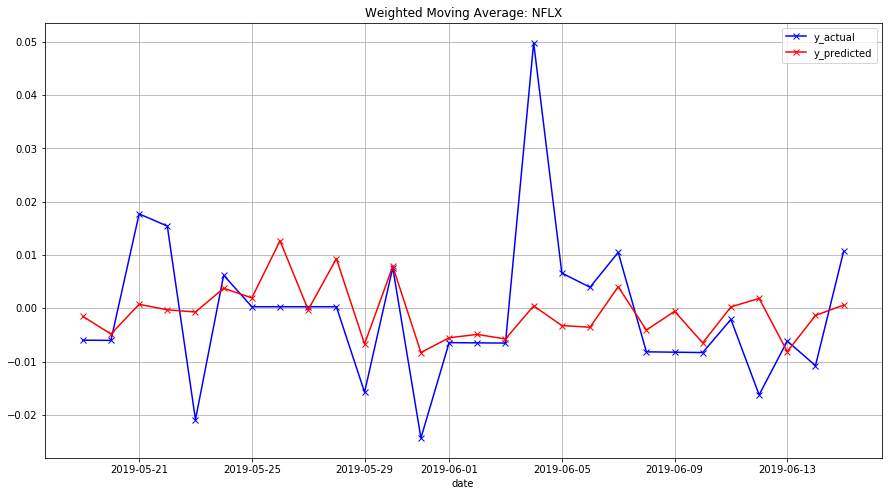

DIS
Cross Validated RMSE: 0.013328592094308455
Cross Validated MAPE: 3.9625208939942227
Cross Validated Direction: 25.0


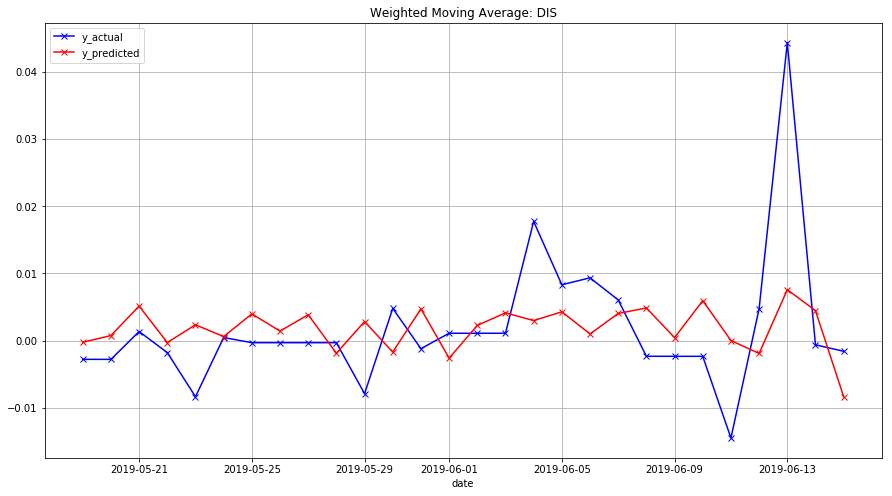

AMZN
Cross Validated RMSE: 0.023974333081338034
Cross Validated MAPE: 6.787748036369095
Cross Validated Direction: 55.0


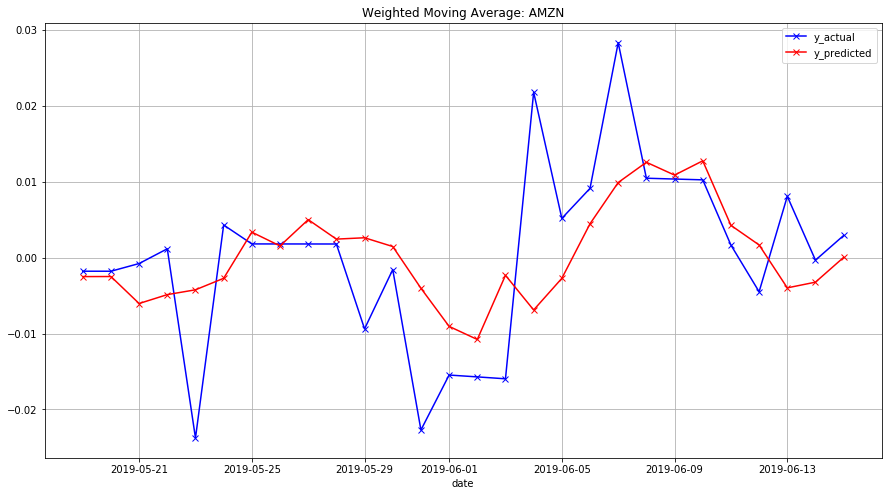

GOOGL
Cross Validated RMSE: 0.01843715518528248
Cross Validated MAPE: 15.82787100536332
Cross Validated Direction: 30.0


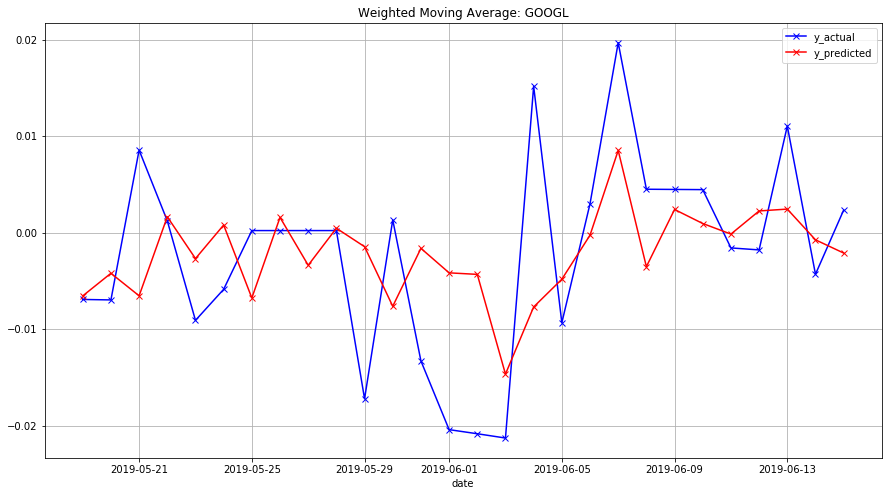

In [113]:
wma_data = [wma_netflix_train, wma_disney_train, wma_amazon_train, wma_google_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in wma_data:
    y = data['stock_growth']
    X = data.drop(['date', 'stock_growth'], axis=1)
    splits = TimeSeriesSplit(n_splits=5)
    lr = LinearRegression()
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lr.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Weighted Moving Average', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    
    model = lr.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Weighted Moving Average: {names[j]}")
    plt.show()
    j += 1

### Coefficients

I expect that the weights given to each additional lag in stock_growth decreases over time while the weights given to each additional lag in sentiment value can vary.

In [239]:
y = wma_netflix_train['stock_growth']
X = wma_netflix_train.drop(['date', 'stock_growth'], axis=1)
lr = LinearRegression()
model = lr.fit(X, y)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
stock_growth_l1,-0.027914
stock_growth_l2,-0.025651
stock_growth_l3,-0.057973
w_avg_sent_l1,0.007115
w_avg_sent_l2,-0.005705
w_avg_sent_l3,0.025658


In [114]:
y = wma_disney_train['stock_growth']
X = wma_disney_train.drop(['date', 'stock_growth'], axis=1)
lr = LinearRegression()
model = lr.fit(X, y)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
stock_growth_l1,0.146395
stock_growth_l2,-0.182343
stock_growth_l3,0.059041
w_avg_sent_l1,-0.003329
w_avg_sent_l2,0.008300
w_avg_sent_l3,-0.011066


In [116]:
y = wma_amazon_train['stock_growth']
X = wma_amazon_train.drop(['date', 'stock_growth'], axis=1)
lr = LinearRegression()
model = lr.fit(X, y)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
stock_growth_l1,0.191488
stock_growth_l2,0.221033
stock_growth_l3,0.162169
w_avg_sent_l1,0.000923
w_avg_sent_l2,-0.014536
w_avg_sent_l3,-0.033888


In [119]:
y = wma_google_train['stock_growth']
X = wma_google_train.drop(['date', 'stock_growth'], axis=1)
lr = LinearRegression()
model = lr.fit(X, y)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
stock_growth_l1,0.221504
stock_growth_l2,0.126004
stock_growth_l3,0.081948
w_avg_sent_l1,-0.003670
w_avg_sent_l2,0.020376
w_avg_sent_l3,-0.008100


In [120]:
model.coef_

array([ 0.22150397,  0.12600381,  0.08194762, -0.00366972,  0.02037608,
       -0.00809963])

The coefficients for the historical stock growth values do seem to decrease over time. On the other hand, it looks like the sentiment value with 3 day lag seems to have the highest coefficient. This contradicts to the significant 2 day lag found from the Granger Causality. 

## Retesting Regression Model with 3 Day Lag

In [123]:
final_scores.groupby('Algorithm').mean().sort_values('RMSE')

,RMSE,MAPE,Direction
Algorithm,,,
"Polynomial Lasso Regression (Degree of 3, Alpha 0.001)",0.012611,3.063756,47.0
Polynomial Ridge Regression (Degree of 3),0.013650,4.391348,47.0
Weighted Moving Average,0.018356,9.122689,40.0
Linear Regression (All Variables),0.023785,14.454652,37.0
Linear Regression (Only Stock),0.077923,24.657409,38.0
Polynomial Regression (Degree of 3),1.116876,128.212886,43.0


In [122]:
final_scores.sort_values(by = ['Company', 'RMSE'])

,Company,Algorithm,RMSE,MAPE,Direction
14,AMZN,Polynomial Ridge Regression (Degree of 3),0.012996,3.865511,36.0
2,AMZN,Linear Regression (Only Stock),0.014983,3.236855,36.0
18,AMZN,"Polynomial Lasso Regression (Degree of 3, Alph...",0.016009,2.809316,32.0
6,AMZN,Linear Regression (All Variables),0.016407,3.628019,36.0
22,AMZN,Weighted Moving Average,0.023974,6.787748,55.0
10,AMZN,Polynomial Regression (Degree of 3),1.228785,66.054658,44.0
17,DIS,"Polynomial Lasso Regression (Degree of 3, Alph...",0.008717,2.145738,48.0
13,DIS,Polynomial Ridge Regression (Degree of 3),0.009714,3.906355,48.0
1,DIS,Linear Regression (Only Stock),0.013188,9.748320,44.0
21,DIS,Weighted Moving Average,0.013329,3.962521,25.0


In [284]:
netflix_fm = netflix_stock.drop(['close', 'volume'], axis = 1)
netflix_tweet_lag = netflix_tweet.shift(3)
netflix_tweet_lag['tmp'] = np.arange(1, len(netflix_tweet_lag)+1)
netflix_fm['tmp'] = np.arange(1, len(netflix_fm)+1)
netflix_fm = netflix_fm.merge(netflix_tweet_lag, on = 'tmp')
netflix_fm = netflix_fm.drop('tmp', axis = 1)
netflix_fm = netflix_fm.dropna()

disney_fm = disney_stock.drop(['close', 'volume'], axis = 1)
disney_tweet_lag = disney_tweet.shift(3)
disney_tweet_lag['tmp'] = np.arange(1, len(disney_tweet_lag)+1)
disney_fm['tmp'] = np.arange(1, len(disney_fm)+1)
disney_fm = disney_fm.merge(disney_tweet_lag, on = 'tmp')
disney_fm = disney_fm.drop('tmp', axis = 1)
disney_fm = disney_fm.dropna()

amazon_fm = amazon_stock.drop(['close', 'volume'], axis = 1)
amazon_tweet_lag = amazon_tweet.shift(3)
amazon_tweet_lag['tmp'] = np.arange(1, len(amazon_tweet_lag)+1)
amazon_fm['tmp'] = np.arange(1, len(amazon_fm)+1)
amazon_fm = amazon_fm.merge(amazon_tweet_lag, on = 'tmp')
amazon_fm = amazon_fm.drop('tmp', axis = 1)
amazon_fm = amazon_fm.dropna()

google_fm = amazon_stock.drop(['close', 'volume'], axis = 1)
google_tweet_lag = google_tweet.shift(3)
google_tweet_lag['tmp'] = np.arange(1, len(google_tweet_lag)+1)
google_fm['tmp'] = np.arange(1, len(google_fm)+1)
google_fm = google_fm.merge(google_tweet_lag, on = 'tmp')
google_fm = google_fm.drop('tmp', axis = 1)
google_fm = google_fm.dropna()

In [285]:
# Split into train test set
netflix_fm_train = netflix_fm[:29]
netflix_fm_test = netflix_fm[29:]
disney_fm_train = disney_fm[:29]
disney_fm_test = disney_fm[29:]
amazon_fm_train = amazon_fm[:29]
amazon_fm_test = amazon_fm[29:]
google_fm_train = google_fm[:29]
google_fm_test = google_fm[29:]

NFLX
Cross Validated RMSE: 0.017880532454858943
Cross Validated MAPE: 3.1872797029860376
Cross Validated Direction: 50.0


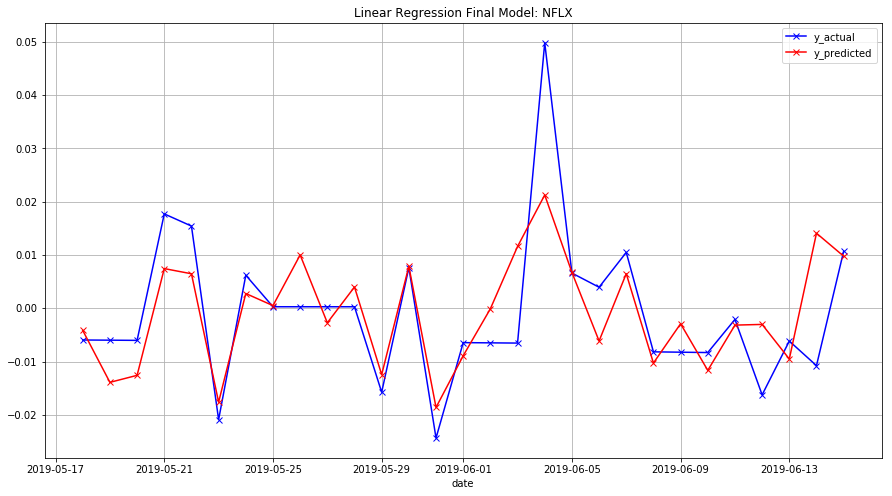

DIS
Cross Validated RMSE: 0.014504055768792063
Cross Validated MAPE: 8.166207583770378
Cross Validated Direction: 45.0


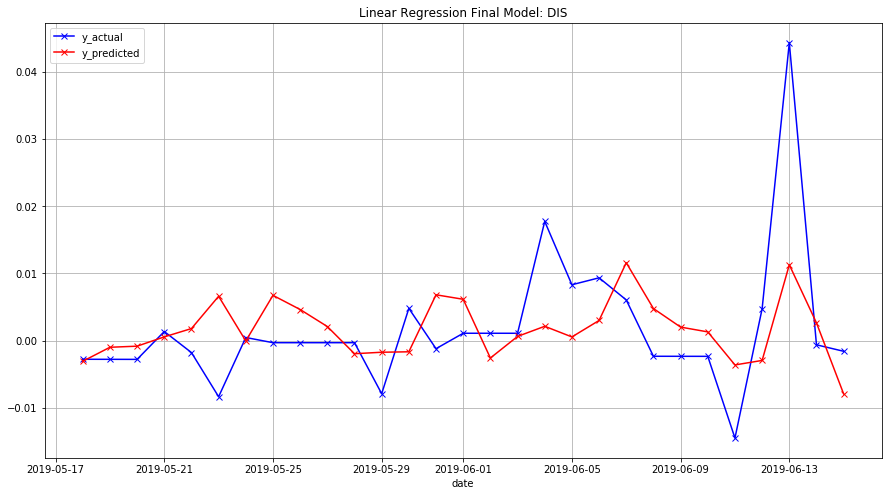

AMZN
Cross Validated RMSE: 0.023972241977223037
Cross Validated MAPE: 2.267775057358199
Cross Validated Direction: 40.0


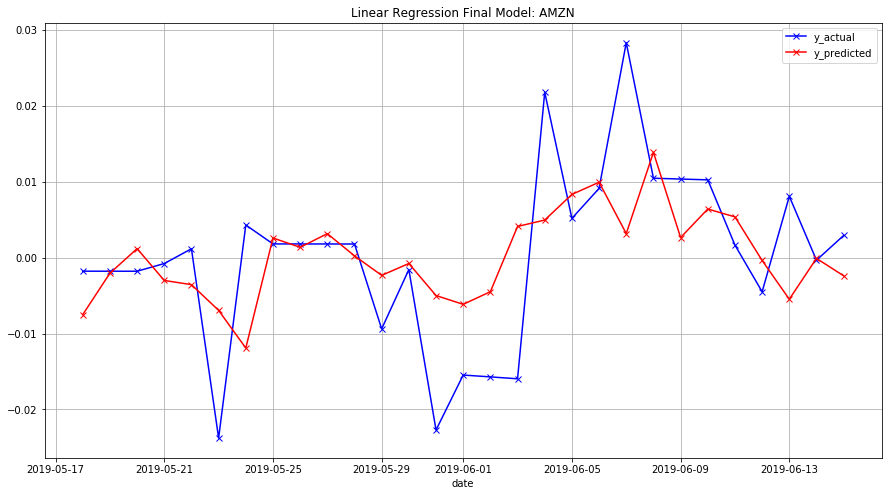

GOOGL
Cross Validated RMSE: 0.020432905321320197
Cross Validated MAPE: 2.4842560280870503
Cross Validated Direction: 35.0


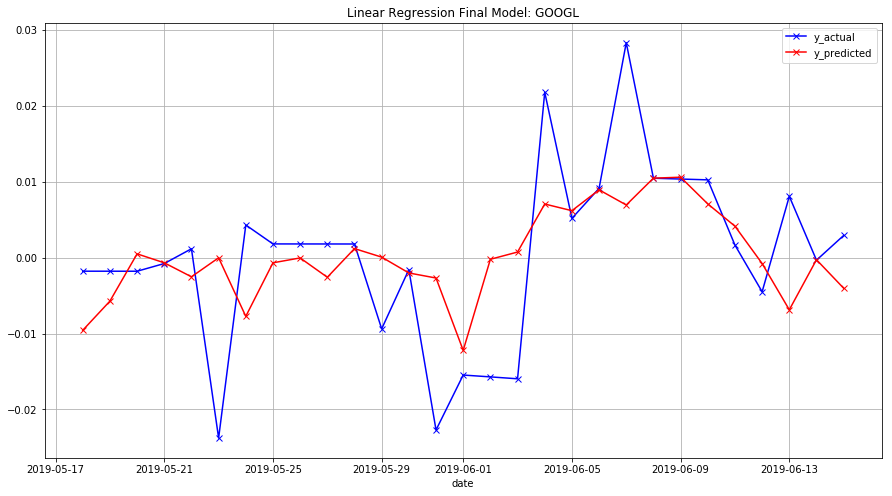

In [378]:
fm_train = [netflix_fm_train, disney_fm_train, amazon_fm_train, google_fm_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0
#fm_scores = pd.DataFrame(columns = ['Company', 'Algorithm', 'RMSE', 'MAPE', 'Direction'])
for data in fm_train:
    y = data['stock_growth']
    X = data.drop(['date', 'stock_growth'], axis=1)
    splits = TimeSeriesSplit(n_splits=5)
    lr = LinearRegression()
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lr.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Linear Regression (3 Day Lag)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lr.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Linear Regression Final Model: {names[j]}")
    plt.show()
    j += 1

NFLX
Cross Validated RMSE: 0.01679269307693914
Cross Validated MAPE: 2.028379319514136
Cross Validated Direction: 35.0


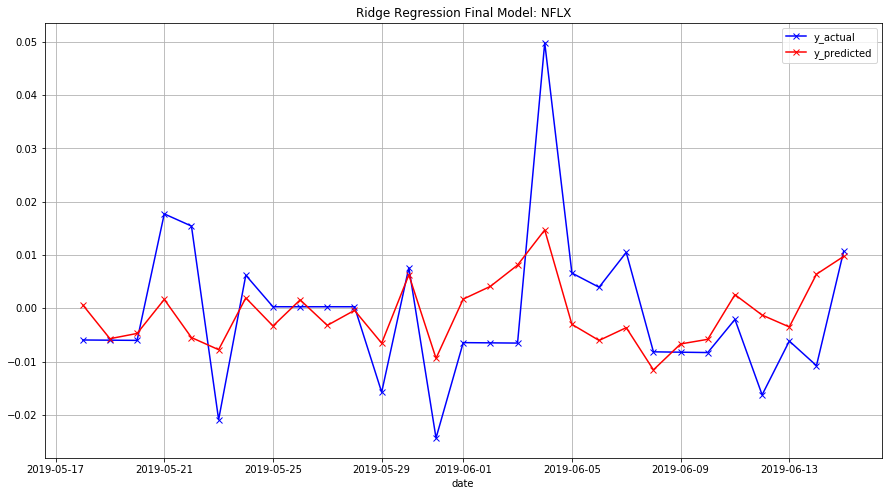

DIS
Cross Validated RMSE: 0.010889832283345433
Cross Validated MAPE: 2.347195986226166
Cross Validated Direction: 30.0


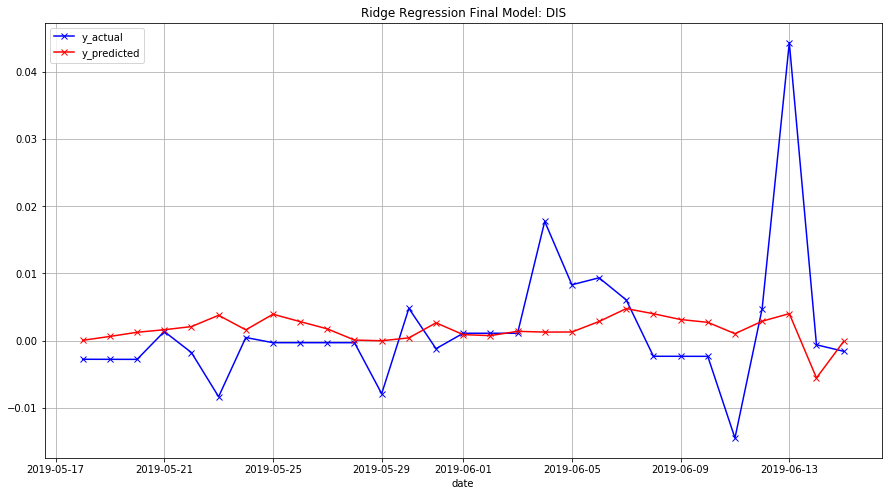

AMZN
Cross Validated RMSE: 0.019212894261690434
Cross Validated MAPE: 2.4446881735269357
Cross Validated Direction: 20.0


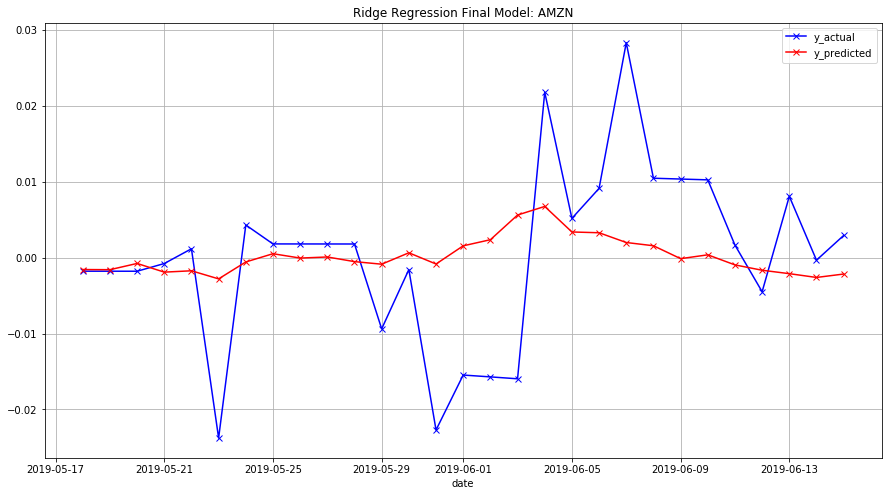

GOOGL
Cross Validated RMSE: 0.019270367682366153
Cross Validated MAPE: 2.3518417226856276
Cross Validated Direction: 15.0


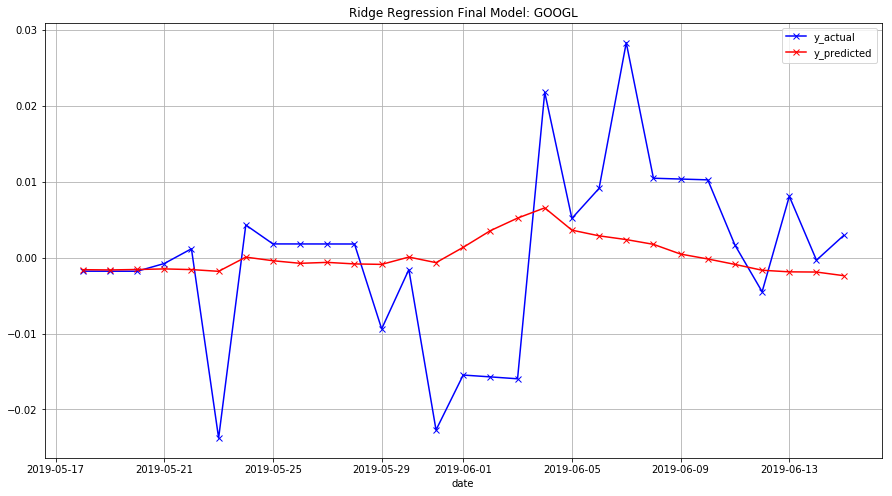

In [379]:
fm_train = [netflix_fm_train, disney_fm_train, amazon_fm_train, google_fm_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in fm_train:
    y = data['stock_growth']
    X = data.drop(['date', 'stock_growth'], axis=1)
    splits = TimeSeriesSplit(n_splits=5)
    lr = Ridge()
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lr.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Ridge Regression (3 Day Lag)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lr.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Ridge Regression Final Model: {names[j]}")
    plt.show()
    j += 1

NFLX
Cross Validated RMSE: 0.016704275380141687
Cross Validated MAPE: 2.332166711522533
Cross Validated Direction: 30.0


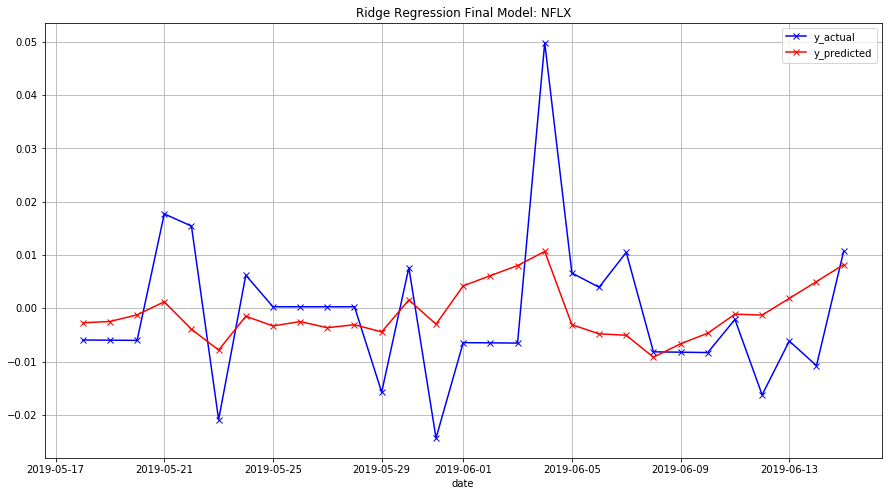

DIS
Cross Validated RMSE: 0.010120207598935319
Cross Validated MAPE: 1.89176736961929
Cross Validated Direction: 30.0


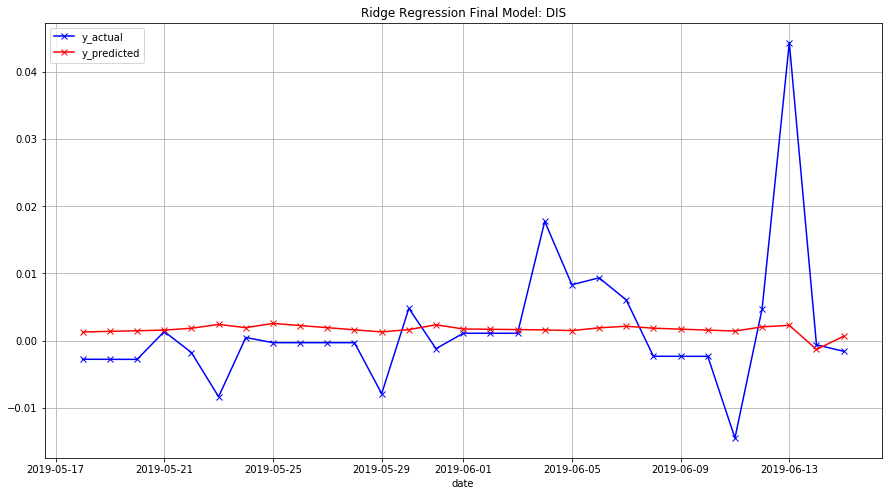

AMZN
Cross Validated RMSE: 0.0175162727629687
Cross Validated MAPE: 2.1310857629114706
Cross Validated Direction: 15.0


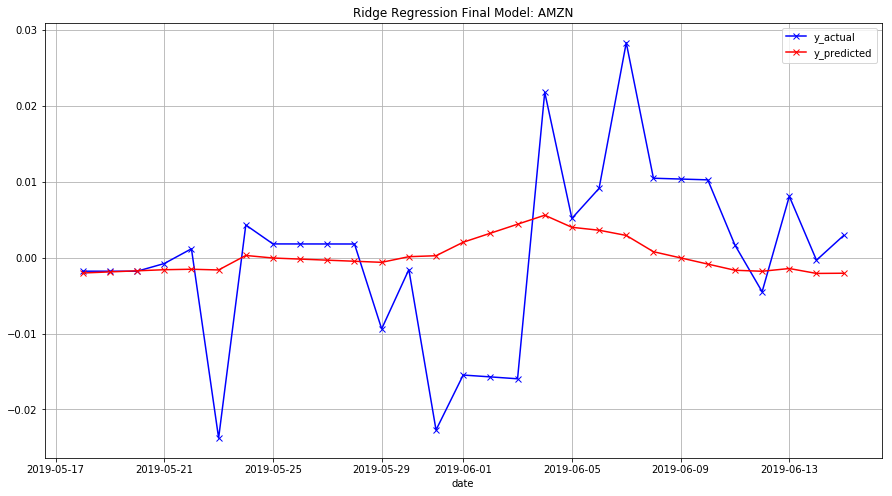

GOOGL
Cross Validated RMSE: 0.0175162727629687
Cross Validated MAPE: 2.1310857629114706
Cross Validated Direction: 15.0


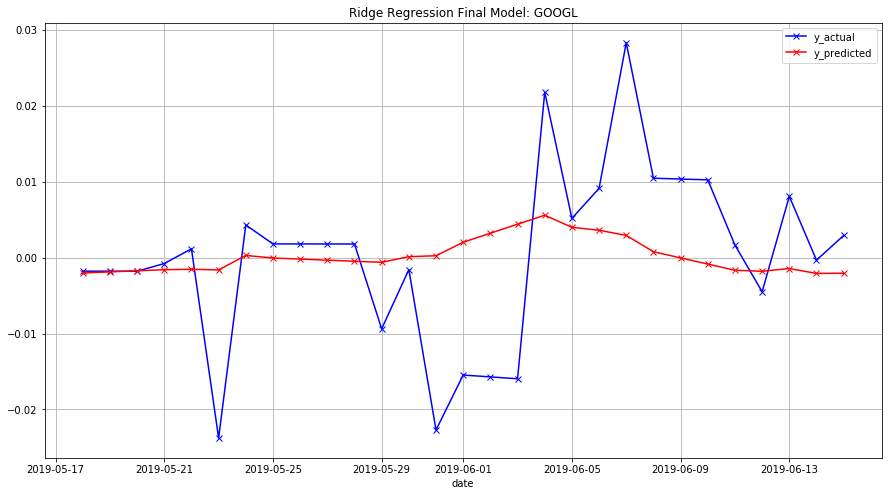

In [380]:
fm_train = [netflix_fm_train, disney_fm_train, amazon_fm_train, google_fm_train]
names = ['NFLX', 'DIS', 'AMZN', 'GOOGL']
j=0

for data in fm_train:
    y = data['stock_growth']
    X = data.drop(['date', 'stock_growth'], axis=1)
    splits = TimeSeriesSplit(n_splits=5)
    lr = Lasso(alpha = 0.001)
    index = 1
    RMSE = []
    MAPE = []
    Direction = []
    for train_index, test_index in splits.split(X):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = lr.fit(x_train, y_train)
        preds = model.predict(x_test)
        RMSE.append(np.mean(np.sqrt(mean_squared_error(y_test, preds))))
        MAPE.append(get_mape(y_test, preds))
        Direction.append(get_direction(y_test, preds))
        index += 1
    print(names[j])
    print(f'Cross Validated RMSE: {np.mean(RMSE)}')
    print(f'Cross Validated MAPE: {np.mean(MAPE)}')
    print(f'Cross Validated Direction: {np.mean(Direction)}')
    final_scores = final_scores.append({'Company': names[j], 'Algorithm': 'Lasso Regression (3 Day Lag, Alpha 0.001)', \
                                        'RMSE': np.mean(RMSE), 'MAPE': np.mean(MAPE), 'Direction': np.mean(Direction)}, ignore_index=True)
    model = lr.fit(X, y)
    y_results = data[['date', 'stock_growth']]
    y_results['predictions'] = model.predict(X)
    rcParams['figure.figsize'] = 15, 8
    ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
    ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
    ax.legend(['y_actual', 'y_predicted'])
    ax.set_title(f"Ridge Regression Final Model: {names[j]}")
    plt.show()
    j += 1

In [381]:
final_scores.sort_values(by = ['Company', 'RMSE'])

,Company,Algorithm,RMSE,MAPE,Direction
10,AMZN,"Lasso Regression (All Variables, Alpha 0.001)",0.012255,2.000775,40.0
14,AMZN,Ridge Regression (All Variables),0.012461,2.139877,40.0
22,AMZN,Polynomial Ridge Regression (Degree of 3),0.012996,3.865511,36.0
2,AMZN,Linear Regression (Only Stock),0.014983,3.236855,36.0
26,AMZN,"Polynomial Lasso Regression (Degree of 3, Alph...",0.016009,2.809316,32.0
6,AMZN,Linear Regression (All Variables),0.016407,3.628019,36.0
42,AMZN,"Lasso Regression (3 Day Lag, Alpha 0.001)",0.017516,2.131086,15.0
38,AMZN,Ridge Regression (3 Day Lag),0.019213,2.444688,20.0
34,AMZN,Linear Regression (3 Day Lag),0.023972,2.267775,40.0
30,AMZN,Weighted Moving Average,0.023974,6.787748,55.0


In [382]:
final_scores.groupby('Algorithm').mean().sort_values(by = ['RMSE'])

,RMSE,MAPE,Direction
Algorithm,,,
"Lasso Regression (All Variables, Alpha 0.001)",0.011462,2.752855,46.0
Ridge Regression (All Variables),0.011771,2.625301,45.0
"Polynomial Lasso Regression (Degree of 3, Alpha 0.001)",0.012611,3.063756,47.0
Polynomial Ridge Regression (Degree of 3),0.013650,4.391348,47.0
"Lasso Regression (3 Day Lag, Alpha 0.001)",0.015464,2.121526,22.5
Ridge Regression (3 Day Lag),0.016541,2.293026,25.0
Weighted Moving Average,0.018356,9.122689,40.0
Linear Regression (3 Day Lag),0.019197,4.026380,42.5
Linear Regression (All Variables),0.023785,14.454652,37.0


## Test Data Results

RMSE: 0.013611465000704063
MAPE: 0.8438720335462534
Direction: 45.45454545454545


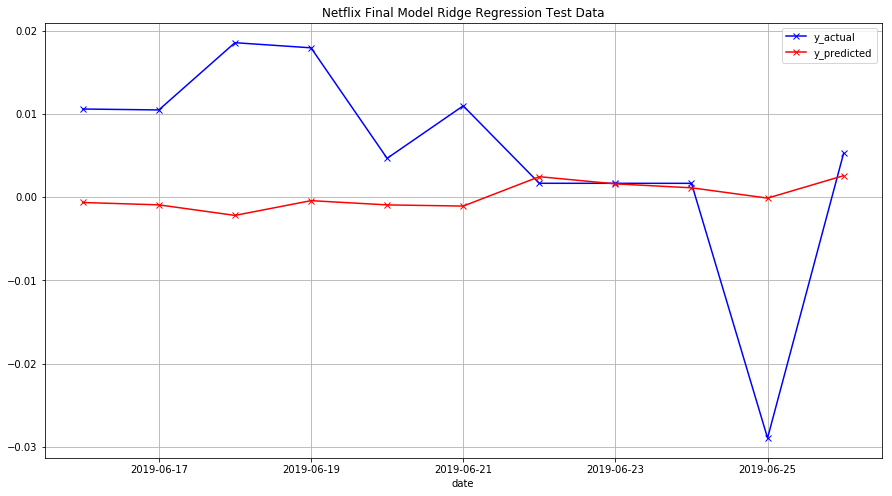

In [125]:
X = netflix_train.drop(['date', 'stock_growth', 'close'], 1)
y = netflix_train['stock_growth']
y_results = netflix_test[['date', 'stock_growth']]
lr = Ridge()
model = lr.fit(X, y)
y_results['predictions'] = model.predict(disney_test.drop(['date', 'stock_growth', 'close'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Netflix Final Model Ridge Regression Test Data')
plt.show()

RMSE: 0.008212030632038406
MAPE: 0.8409403698482094
Direction: 45.45454545454545


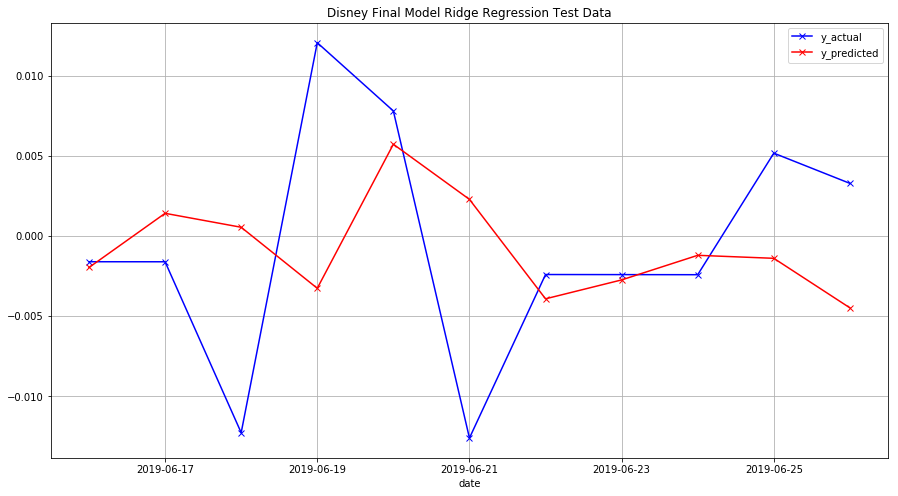

In [127]:
X = disney_train.drop(['date', 'stock_growth', 'close'], 1)
y = disney_train['stock_growth']
y_results = disney_test[['date', 'stock_growth']]
lr = Ridge()
model = lr.fit(X, y)
y_results['predictions'] = model.predict(disney_test.drop(['date', 'stock_growth', 'close'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Disney Final Model Ridge Regression Test Data')
plt.show()

RMSE: 0.007704228854179071
MAPE: 2.2070447921152576
Direction: 18.181818181818183


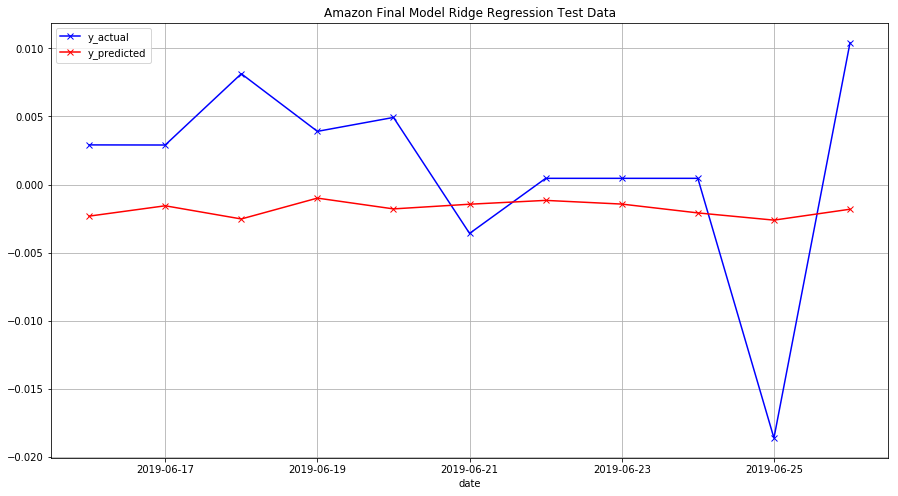

In [128]:
X = amazon_train.drop(['date', 'stock_growth', 'close'], 1)
y = amazon_train['stock_growth']
y_results = amazon_test[['date', 'stock_growth']]
lr = Ridge()
model = lr.fit(X, y)
y_results['predictions'] = model.predict(amazon_test.drop(['date', 'stock_growth','close'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Amazon Final Model Ridge Regression Test Data')
plt.show()

RMSE: 0.009693435136333773
MAPE: 1.4416855934651203
Direction: 54.54545454545454


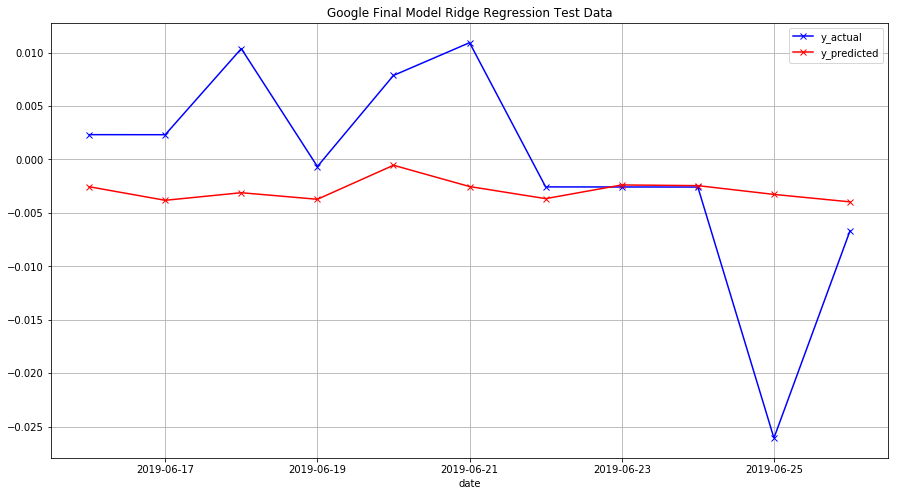

In [129]:
X = google_train.drop(['date', 'stock_growth', 'close'], 1)
y = google_train['stock_growth']
y_results = google_test[['date', 'stock_growth']]
lr = Ridge()
model = lr.fit(X, y)
y_results['predictions'] = model.predict(google_test.drop(['date', 'stock_growth', 'close'], 1))
print(f'RMSE: {np.mean(np.sqrt(mean_squared_error(y_results.stock_growth.values, y_results.predictions.values)))}')
print(f'MAPE: {get_mape(y_results.stock_growth.values, y_results.predictions.values)}')
print(f'Direction: {get_direction(y_results.stock_growth.values, y_results.predictions)}')
ax = y_results.plot(x='date', y='stock_growth', style='bx-', grid=True)
ax = y_results.plot(x='date', y='predictions', style = 'rx-', grid = True, ax= ax)
ax.legend(['y_actual', 'y_predicted'])
ax.set_title('Google Final Model Ridge Regression Test Data')
plt.show()